In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, PredictionErrorDisplay
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, SelectPercentile
# https://jundongl.github.io/scikit-feature/algorithms.html
from skfeature.function.statistical_based import gini_index


from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV


# from tpot import TPOTRegressor

import dtreeviz

from textwrap import wrap
from functools import reduce

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, get_categorical_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model, get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf, get_feature_importance_logistic_regressison
from main.components.feature_importance_methods import rename_importnace_col, merge_feature_importances, rank_importances

import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro  IGF-1 ng/ml (N: 100-311)  proBNP  AMH (ng/ml) *7,14=pmol/l  weight  height (cm)        BMI  systolic BP (ciśnienie skurczowe)  diastolic BP (ciśnienie rozskurczowe)  Hypertension  Waist Circumference (WC)  WC>88  Hip Circumference (HC)  WHR (Waist/Hip ratio)  WHR>0,85 (WHO)  WHR>0,8 (NIDDK)  WHTR (Waist/Height Ratio)  WHTR>0,5  overweight/obesity 0-normal/low, 1-overweight, 2-obesity  irregular cycles (0-nie, 1-tak)  ovulation (0-brak, 1-obecna)  PCO ovary morfology in USG (0-brak, 1--obecna)  stromal hypertrophy in ovary (0-brak, 1-obecny)  acne  hirsutism  FG score (Ferriman-Gallway score - stopień androgenizacji)  hyperandrogenism  hypothyroidism  Volume of the thyroid  Right Lobe  Volume of the thyroid  Left Lobe  thyroid volume  nodules 0-lack, 1-RL,  2-LL, 3-both  chronic thyroiditis  Vole of the Right Ovary  Volume of the  Left Ovary  ovaries volume - total  follicules >12  WBC x10^3/ul  neutrophil x10^3/ul  \
418                                                         1                     150.0     NaN                       NaN    97.0        160.0  37.890625                              140.0                                   87.0           0.0                     108.0    1.0                   109.0               0.990826             1.0              1.0                   0.675000       1.0                                                       2.0                              1.0                           0.0                                             1.0                                              0.0   0.0        1.0                                                         8.0               1.0             1.0                              1.485                             3.255           4.740                                  2.0                  1.0                     7.09                       8.24                   15.33             1.0          8.67                 4.82   
153                                                         0                       NaN   70.97                       NaN    54.0        163.0  20.324438                                NaN                                    NaN           NaN                      70.0    0.0                    79.0               0.886076             1.0              1.0                   0.429448       0.0                                                       0.0                              1.0                           0.0                                             0.0                                              0.0   0.0        0.0                                                         NaN               NaN             1.0                                NaN                               NaN             NaN                                  0.0                  1.0                      NaN                        NaN                     NaN             NaN           NaN                  NaN   
536                                                         1                     297.0    9.01                 15.000000    70.0        160.0  27.343750                              125.0                                   80.0           0.0                      93.0    1.0                    93.0               1.000000             1.0              1.0                   0.581250       1.0                                                       1.0                              1.0                           0.0                                             1.0                                              1.0   1.0        0.0                                                         6.0               1.0             0.0                              3.458                             2.880           6.338                                  0.0                  0.0                     9.25                      10.50                   19.75             1.0          5.12                 2.84   
250                          

<Axes: >

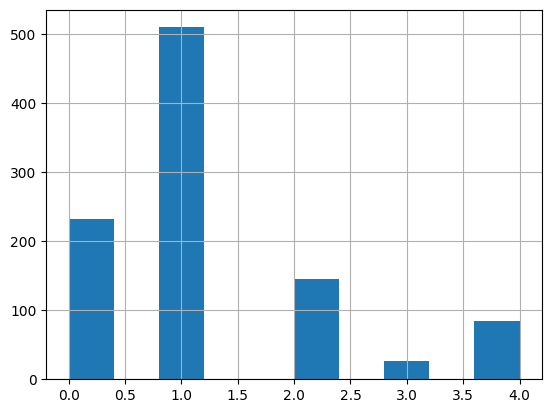

In [3]:
df[PCO].hist()

In [4]:
df.shape

(999, 135)

# Model selection for PCO

In [5]:
CLASS_NAMES = ['healthy', 'PCOS', 'FHA', 'POF', 'High Andro']

### Remove the `POF` class

In [6]:
df.loc[df[PCO] == 3, PCO] = np.nan

#  change all 4s to 3s for the need of the visualisation algorithm
df[PCO] = np.where(df[PCO] == 4, 3, df[PCO])


CLASS_NAMES = ['healthy', 'PCOS', 'FHA', 'High Andro']

Remove `POF`,  `FHA`, `High Andro` classes

In [7]:

# df.loc[(df[PCO] != 0) & (df[PCO] != 1), PCO] = np.nan

#  CLASS_NAMES = ['healthy', 'PCOS']

In [8]:
df.shape

(999, 135)

In [9]:
df_cleaned = df.dropna(subset=[PCO])

X, y = df_cleaned.drop(columns=[PCO]), df_cleaned[PCO]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Hyperparameter tuning

In [10]:
continuous_preprocessor_tree = Pipeline([('imputer', KNNImputer(n_neighbors=7))])

continuous_preprocessor = Pipeline([('scaler', MinMaxScaler()), ('imputer', KNNImputer(n_neighbors=7))])
categorical_preprocessor = Pipeline([('imputer', IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=10, n_jobs=-1), max_iter=40, initial_strategy='most_frequent')), ('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))])


preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])

### Decision Tree

In [11]:
model_tree = DecisionTreeClassifier()
param_grid_tree = {
    'model__criterion': ['gini'],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [4, 5, 6],
    'model__min_samples_leaf': [3, 4, 5],
    'model__class_weight': [None],
}

tree_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_tree, continuous_preprocessor_tree, categorical_preprocessor, param_grid_tree, scoring_metric='f1_weighted')
tree_h_scores.sort_values(by='mean_test_score', ascending=False)

Fitting 15 folds for each of 27 candidates, totalling 405 fits
Best parameters: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}
Best score (f1_weighted): 0.6343468471565181


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


params  mean_train_score  mean_test_score
9   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.734834         0.634347
11  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}          0.734621         0.634251
14  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.732912         0.633983
13  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.731942         0.633410
16  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.730842         0.633389
12  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4}          0.732912         0.633212
17  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.730688         0.632961
10  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}          0.734216         0.632881
15  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.731654         0.632785
23  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.784410         0.628281
22  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.784489         0.627060
24  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.780343         0.626694
20  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}          0.786393         0.626464
21  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4}          0.784921         0.625864
26  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.780345         0.625021
19  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}          0.787566         0.624565
25  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.781118         0.623099
18  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.788965         0.621972
6   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.666272         0.617181
0   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.667202         0.616687
8   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.666272         0.616667
7   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.

In [11]:
model = DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_leaf=2, min_samples_split=5, splitter='random')

tuned_df = compare_random_states(X_train, y_train, model, PCO, continuous_preprocessor_tree, categorical_preprocessor)
tuned_df.abs.sort_values(by='cv_score', ascending=False).head(5)

100%|██████████| 99/99 [15:19<00:00,  9.28s/it]


cv_score
18 -0.493617
64 -0.504952
75 -0.507124
45 -0.509694
55 -0.509711

### Logistic Regression

Fitting 15 folds for each of 8 candidates, totalling 120 fits
Best parameters: {'model__C': 2}
Best score (f1_weighted): 0.715119149273523


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


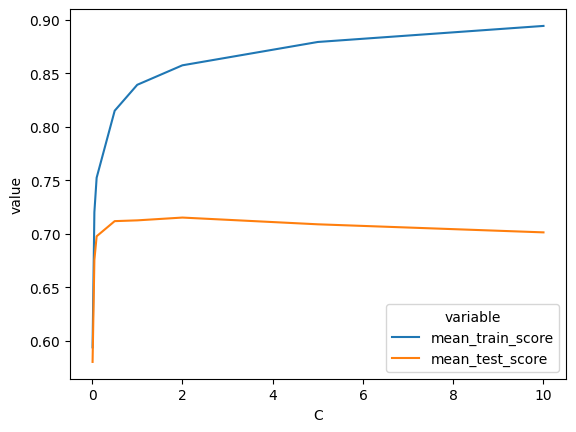

C  mean_train_score  mean_test_score
0  0.01          0.593938         0.580321
1  0.05          0.720085         0.675474
2   0.1          0.752316         0.697647
3   0.5          0.814890         0.711791
4     1          0.839098         0.712511
5     2          0.857298         0.715119
6     5          0.879089         0.708827
7    10          0.894077         0.701297

In [12]:
model_lr = LogisticRegression(multi_class='multinomial', max_iter=100000, n_jobs=-1)

param_grid_lr = {
    'model__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10],
}

lr_h_scores = hyperparameter_tuning_linear(X_train, y_train, PCO, model_lr, continuous_preprocessor, categorical_preprocessor, param_grid_lr, main_parameter='C', scoring_metric='f1_weighted')
lr_h_scores

Selected C=0.5

### Random Forest

In [72]:
model_rf = RandomForestClassifier(n_jobs=-1)

param_grid_rf = {
    'model__criterion': ['gini'],
    'model__class_weight': ['balanced_subsample'],
    'model__n_estimators': [200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [3, 4, 5],
    'model__min_samples_leaf': [5, 6, 7],
}

rf_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_rf, continuous_preprocessor_tree, categorical_preprocessor, param_grid_rf, scoring_metric='f1_weighted')
rf_h_scores.sort_values(by='mean_test_score', ascending=False)

Fitting 15 folds for each of 9 candidates, totalling 135 fits
Best parameters: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best score (f1_weighted): 0.7826160815395791


params  mean_train_score  mean_test_score
8  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.913822         0.782616
4  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.928839         0.780565
2  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.948672         0.780479
3  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.930861         0.778460
1  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.948119         0.778261
5  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.929055         0.778234
6  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.915132         0.777261
0  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.947720         0.775780
7  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.912644         0.774311

In [12]:
model = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=5, class_weight='balanced_subsample')

tuned_df = compare_random_states(X_train, y_train, model, PCO, continuous_preprocessor_tree, categorical_preprocessor)
tuned_df.abs().sort_values(by='cv_score', ascending=False).head(5)

100%|██████████| 99/99 [19:35<00:00, 11.88s/it]


cv_score
25  -0.39638
56 -0.398133
70 -0.399275
94 -0.402765
98 -0.405842

### SVM

In [ ]:
model_svc = SVC(n_jobs=-1, decision_function_shape='ovo')

param_grid_svc = {
    'model__kernel': ['linear', 'rbf', 'sigmoid'],
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': [0.1, 1, 10],
    'model__epsilon': [0.1, 0.2, 0.3],
}

svc_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_svc, continuous_preprocessor, categorical_preprocessor, param_grid_svc, scoring_metric='f1_weighted')
svc_h_scores.sort_values(by='mean_test_score', ascending=False)

## Best models

In [11]:
def plot_confussion_matrices(model, X_train, y_train, X_test, y_test, class_names):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    ConfusionMatrixDisplay.from_estimator(
        model,
        X_train,
        y_train,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        ax=axs[0],
    )
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        ax=axs[1],
    )

    axs[0].set_title('Training Set')
    axs[1].set_title('Test Set')
    plt.tight_layout()
    plt.show()




def validate_model(model, target_attribute, X_train, y_train, X_test, y_test, continuous_preprocessor, categorical_preprocessor, feature_importance_method):

    preprocessor = ColumnTransformer(
        verbose_feature_names_out=False,
        transformers=[
            ('num', continuous_preprocessor, get_continuous_attributes_except(target_attribute)),
            ('cat', categorical_preprocessor, get_categorical_attributes_except(target_attribute))
        ])
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

    pipeline.fit(X_train, y_train)

    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    plot_confussion_matrices(pipeline, X_train, y_train, X_test, y_test, CLASS_NAMES)

    report_train = classification_report(y_train, y_pred_train, target_names=CLASS_NAMES)

    report_test = classification_report(y_test, y_pred_test,  target_names=CLASS_NAMES)


    print('Training set')
    print(report_train)
    
    print('Test set')
    print(report_test)

    feature_importnces = feature_importance_method(pipeline, target_attribute)

    return feature_importnces, pipeline


### DecisionTree

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


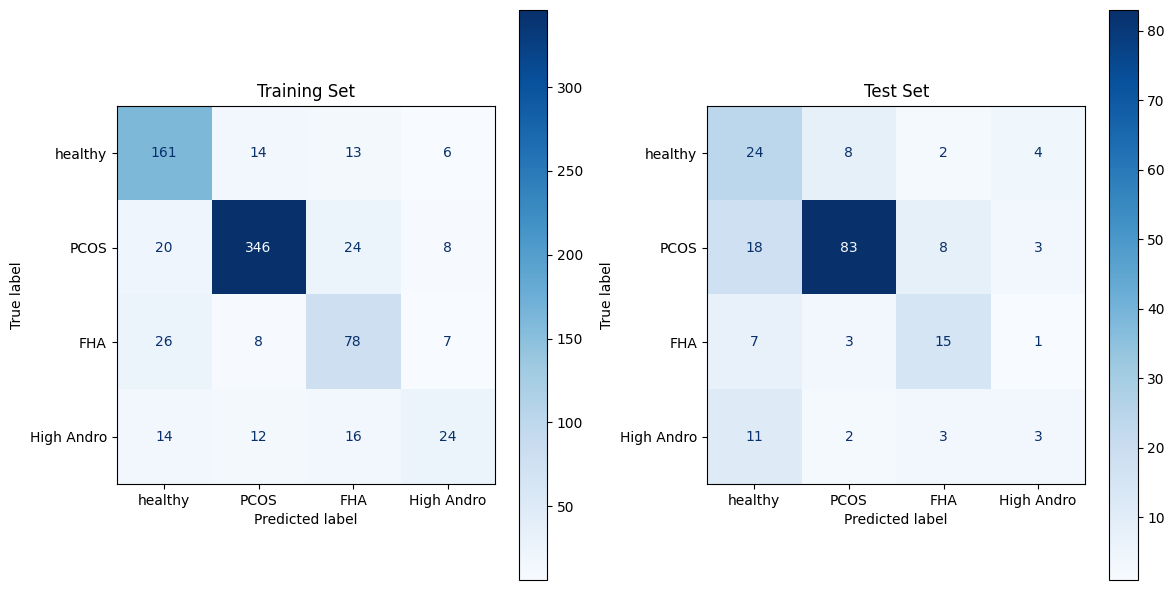

Training set
              precision    recall  f1-score   support

     healthy       0.73      0.83      0.78       194
        PCOS       0.91      0.87      0.89       398
         FHA       0.60      0.66      0.62       119
  High Andro       0.53      0.36      0.43        66

    accuracy                           0.78       777
   macro avg       0.69      0.68      0.68       777
weighted avg       0.78      0.78      0.78       777

Test set
              precision    recall  f1-score   support

     healthy       0.40      0.63      0.49        38
        PCOS       0.86      0.74      0.80       112
         FHA       0.54      0.58      0.56        26
  High Andro       0.27      0.16      0.20        19

    accuracy                           0.64       195
   macro avg       0.52      0.53      0.51       195
weighted avg       0.67      0.64      0.65       195



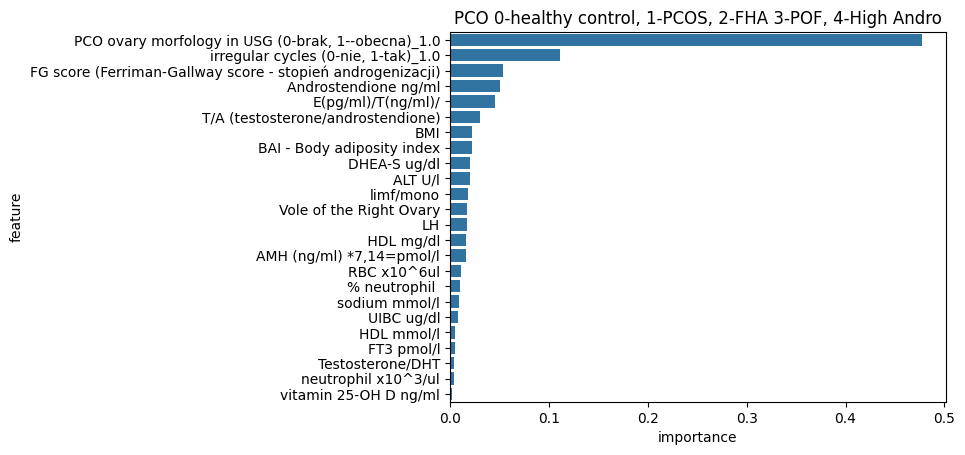

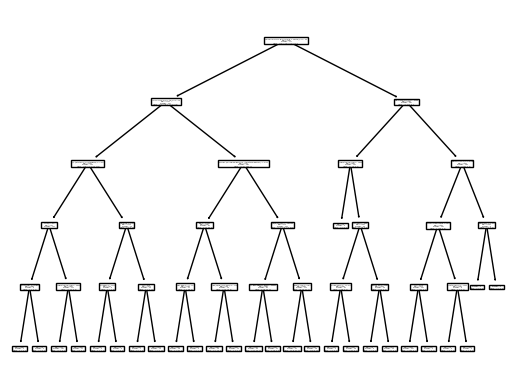

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


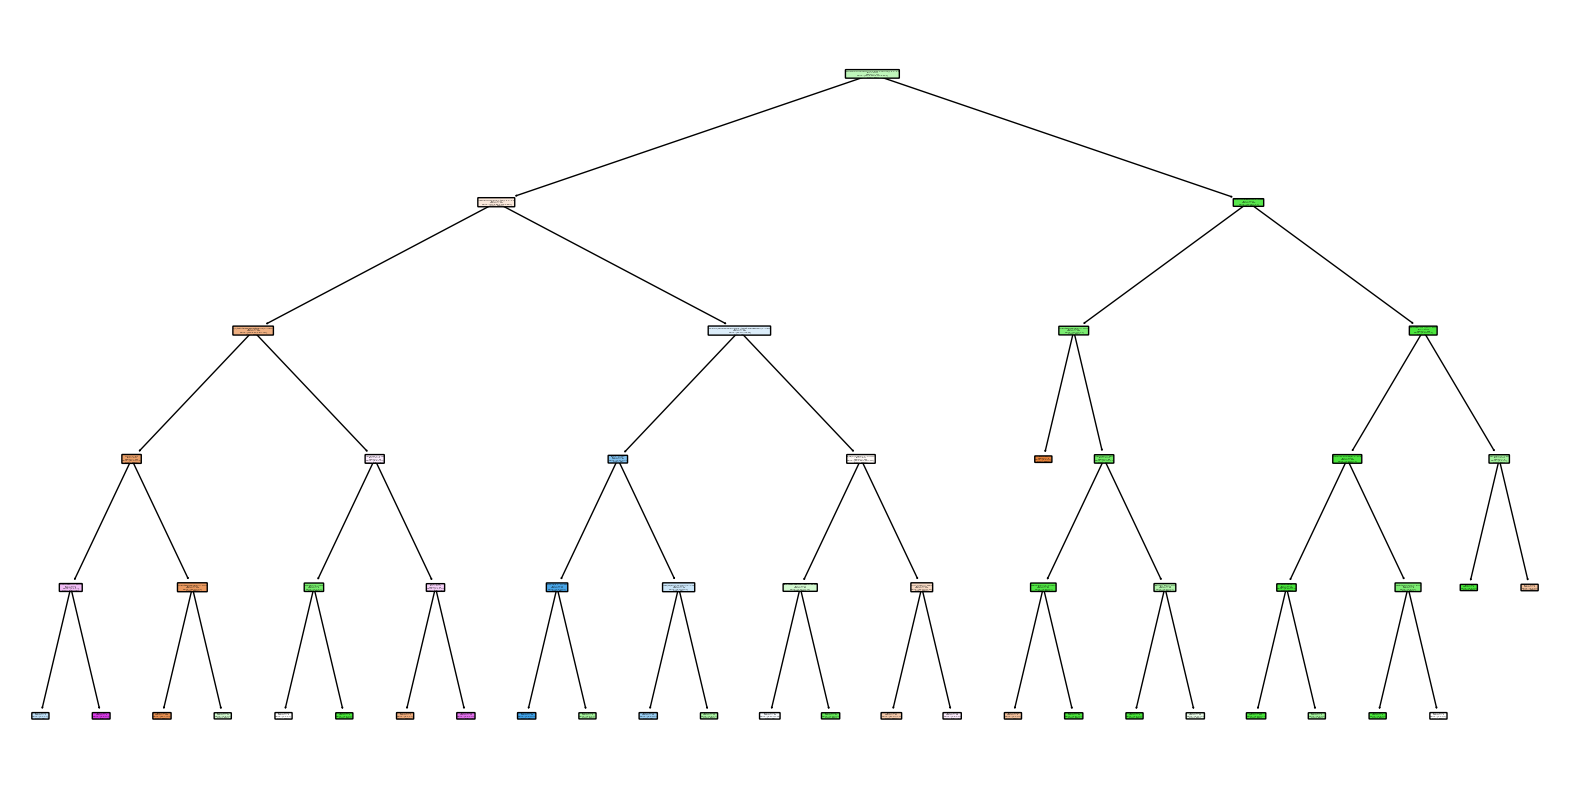

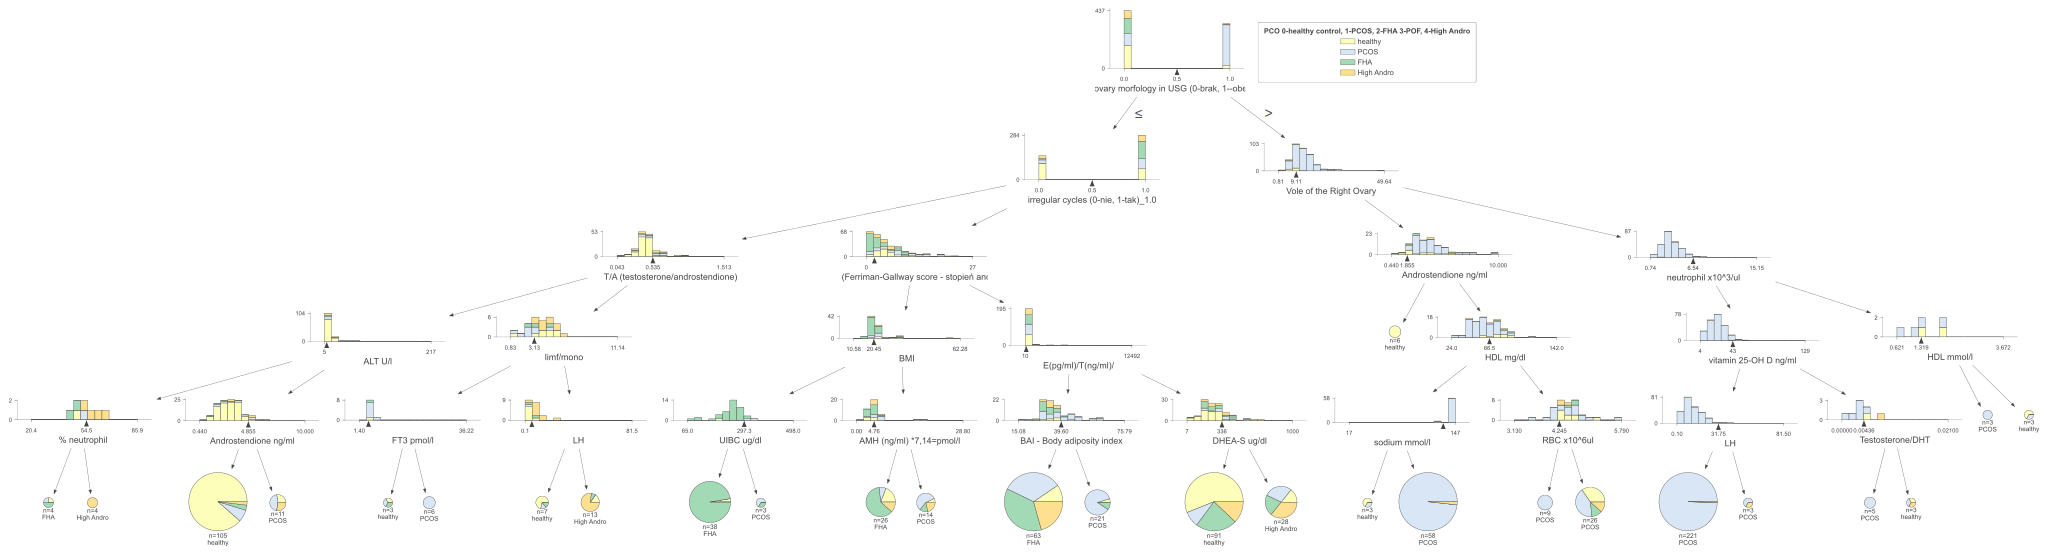

In [12]:
model_tree = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=3, min_samples_split=6, class_weight=None, splitter='best')

feature_importnces_tree, pipeline_tree = validate_model(model_tree, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor_tree, categorical_preprocessor, get_feature_importance_tree)

X_transformed = pipeline_tree['preprocessor'].fit_transform(X_train, y_train)
column_names = pipeline_tree['preprocessor'].get_feature_names_out()

plt.figure(figsize=(20,10))
plot_tree(pipeline_tree['model'], filled=True, rounded=True, feature_names=column_names, class_names=CLASS_NAMES)
plt.savefig('charts/trees/PCO_tree.pdf')
plt.show()

viz_model = dtreeviz.model(pipeline_tree['model'],
                        X_train=X_transformed,
                        y_train=y_train.astype(int),
                        feature_names=column_names,
                        target_name=PCO,
                        class_names=CLASS_NAMES,
                        )

viz_model.view(scale=1.8)

In [13]:
feature_importnces_tree

feature  importance
124          PCO ovary morfology in USG (0-brak, 1--obecna)_1.0    0.477608
122                         irregular cycles (0-nie, 1-tak)_1.0    0.111643
12   FG score (Ferriman-Gallway score - stopień androgenizacji)    0.054048
108                                        Androstendione ng/ml    0.050251
98                                           E(pg/ml)/T(ng/ml)/    0.045374
112                           T/A (testosterone/androstendione)    0.030562
5                                                           BMI    0.022155
69                                   BAI - Body adiposity index    0.022071
94                                                 DHEA-S ug/dl    0.020633
55                                                      ALT U/l    0.020145
45                                                    limf/mono    0.018566
16                                      Vole of the Right Ovary    0.017723
91                                                           LH    0.017422
60                                                    HDL mg/dl    0.016409
2                                      AMH (ng/ml) *7,14=pmol/l    0.016010
30                                                  RBC x10^6ul    0.011454
25                                                % neutrophil     0.009830
49                                                sodium mmol/l    0.008835
73                                                   UIBC ug/dl    0.008499
61                                                   HDL mmol/l    0.004766
86                                                   FT3 pmol/l    0.004766
111                                            Testosterone/DHT    0.004468
20                                          neutrophil x10^3/ul    0.004355
107                                       vitamin 25-OH D ng/ml    0.002408

In [14]:
v = viz_model.view(scale=1.8)
v.show()
v.save("charts/trees/pco_multiclass_decision_tree.svg")  

### RandomForest

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


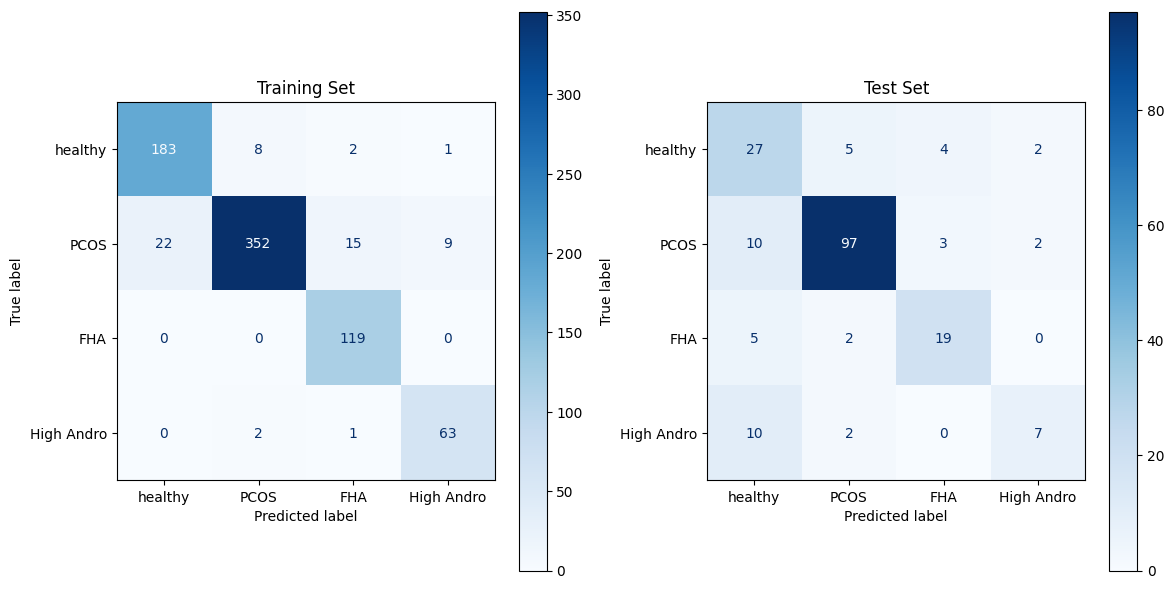

Training set
              precision    recall  f1-score   support

     healthy       0.89      0.94      0.92       194
        PCOS       0.97      0.88      0.93       398
         FHA       0.87      1.00      0.93       119
  High Andro       0.86      0.95      0.91        66

    accuracy                           0.92       777
   macro avg       0.90      0.95      0.92       777
weighted avg       0.93      0.92      0.92       777

Test set
              precision    recall  f1-score   support

     healthy       0.52      0.71      0.60        38
        PCOS       0.92      0.87      0.89       112
         FHA       0.73      0.73      0.73        26
  High Andro       0.64      0.37      0.47        19

    accuracy                           0.77       195
   macro avg       0.70      0.67      0.67       195
weighted avg       0.79      0.77      0.77       195



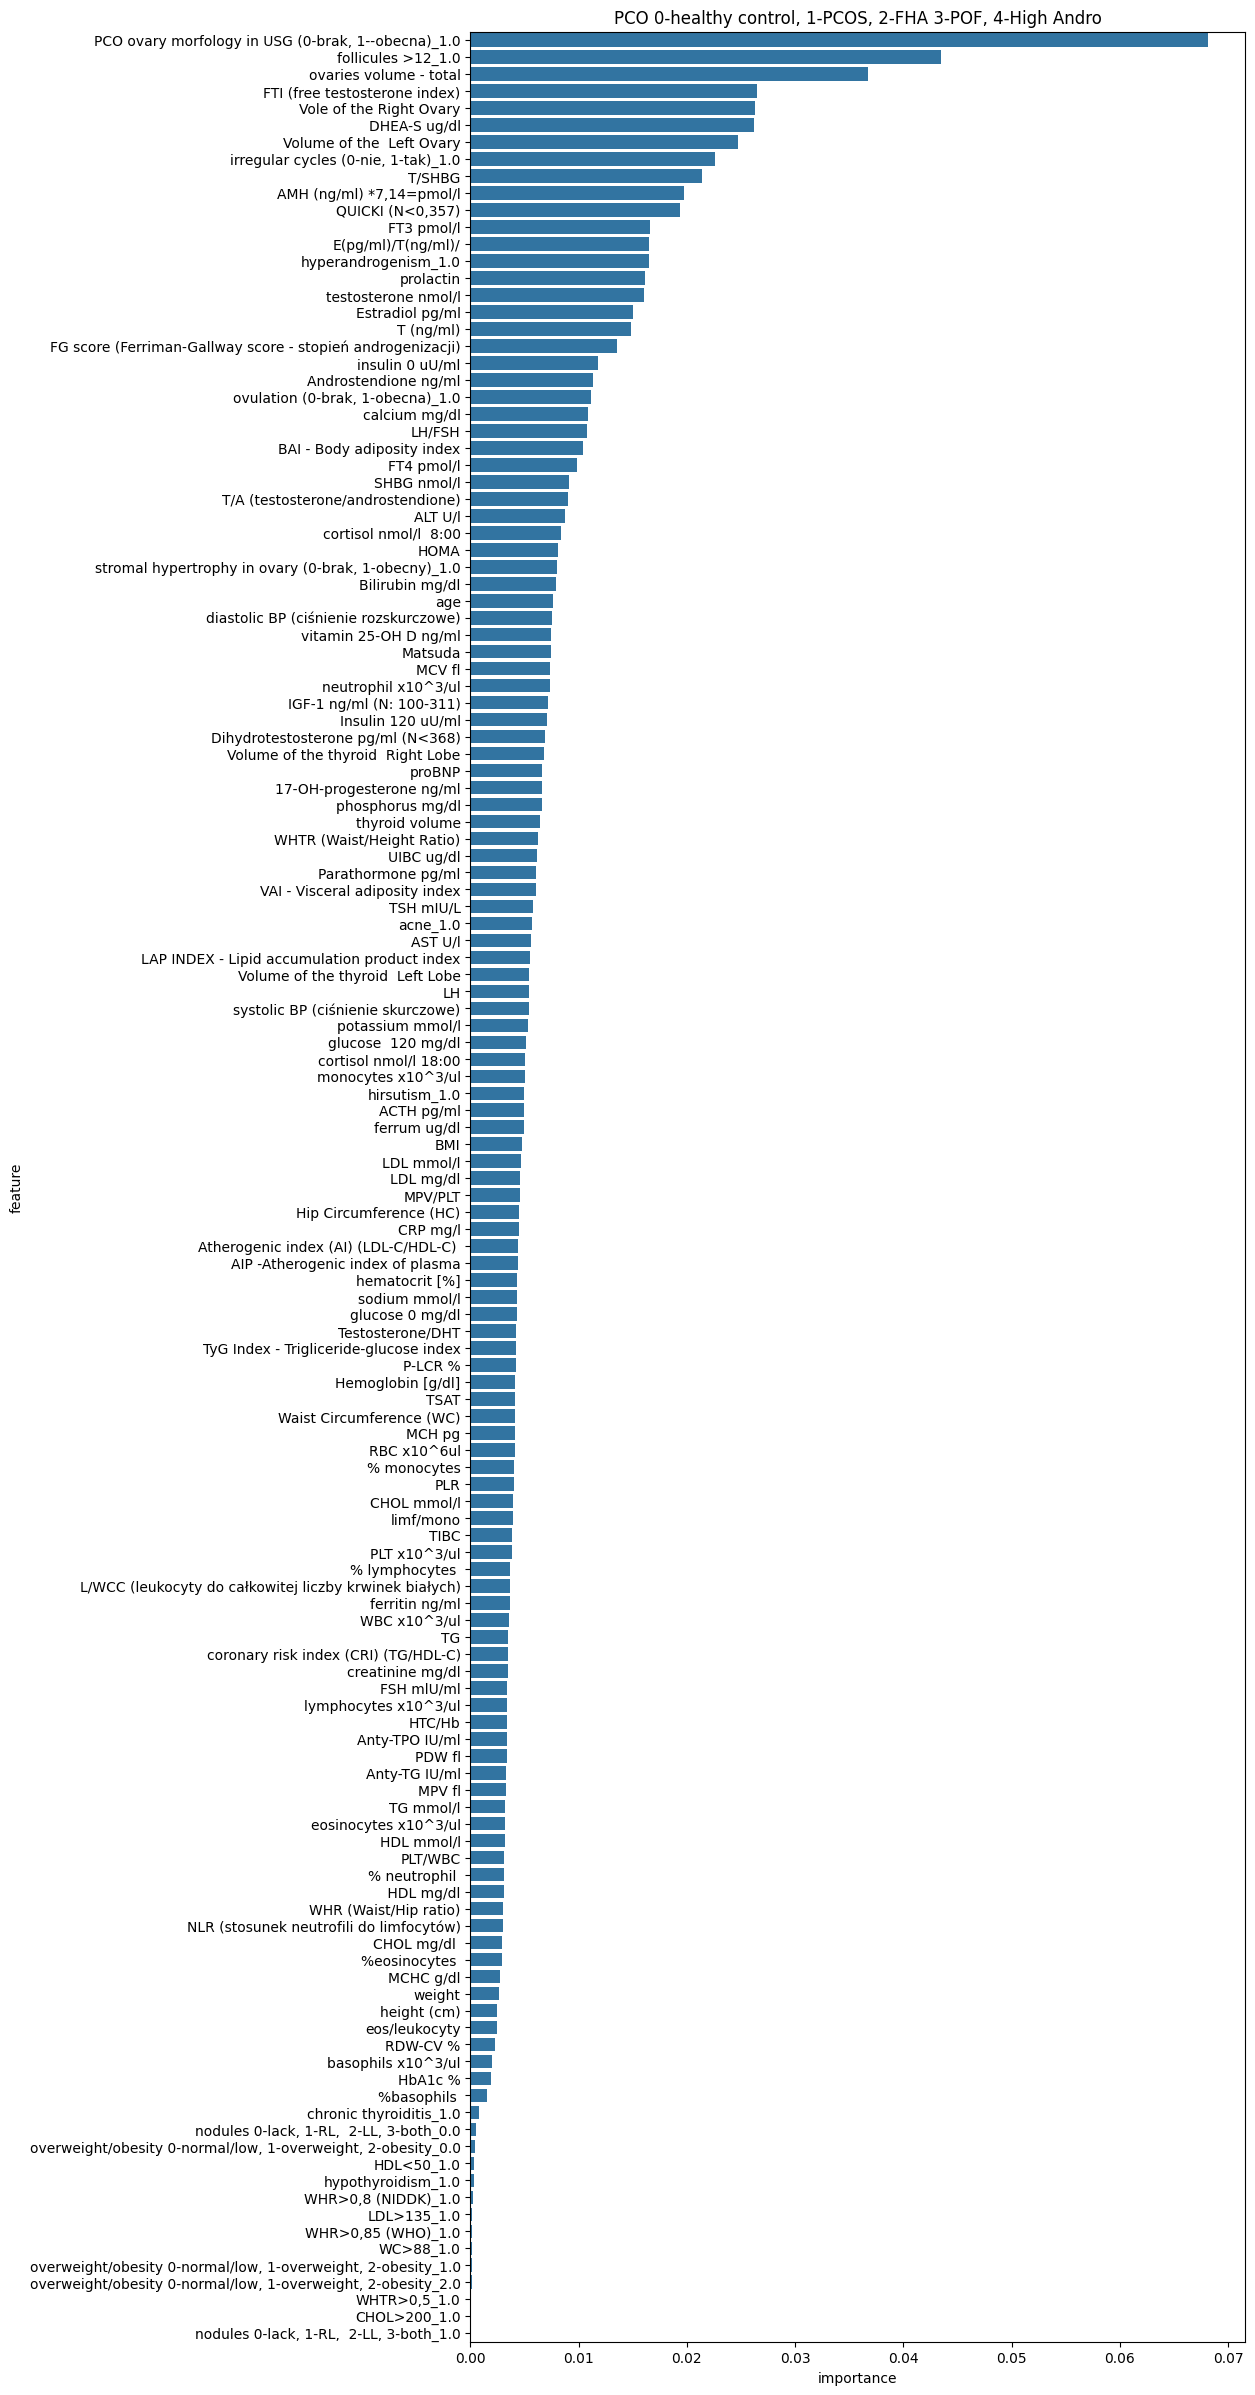

In [15]:
model_rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=5, class_weight='balanced_subsample', random_state=72)

feature_importnces_rf, pipeline_rf = validate_model(model_rf, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor_tree, categorical_preprocessor, get_feature_importance_rf)

### Logistic Regression

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


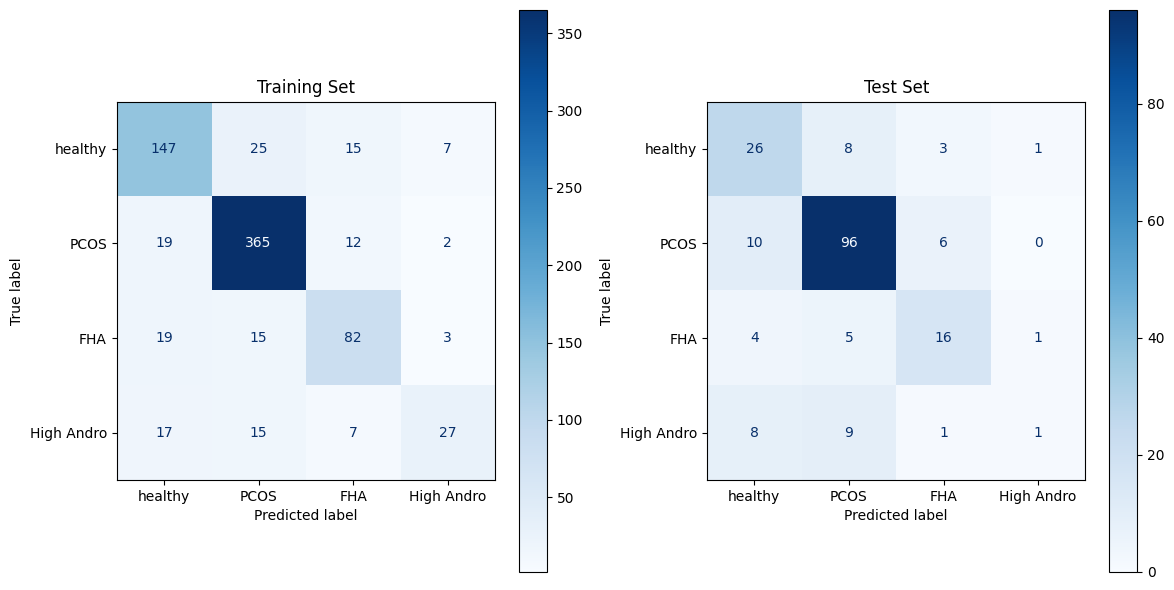

Training set
              precision    recall  f1-score   support

     healthy       0.73      0.76      0.74       194
        PCOS       0.87      0.92      0.89       398
         FHA       0.71      0.69      0.70       119
  High Andro       0.69      0.41      0.51        66

    accuracy                           0.80       777
   macro avg       0.75      0.69      0.71       777
weighted avg       0.79      0.80      0.79       777

Test set
              precision    recall  f1-score   support

     healthy       0.54      0.68      0.60        38
        PCOS       0.81      0.86      0.83       112
         FHA       0.62      0.62      0.62        26
  High Andro       0.33      0.05      0.09        19

    accuracy                           0.71       195
   macro avg       0.58      0.55      0.54       195
weighted avg       0.69      0.71      0.69       195



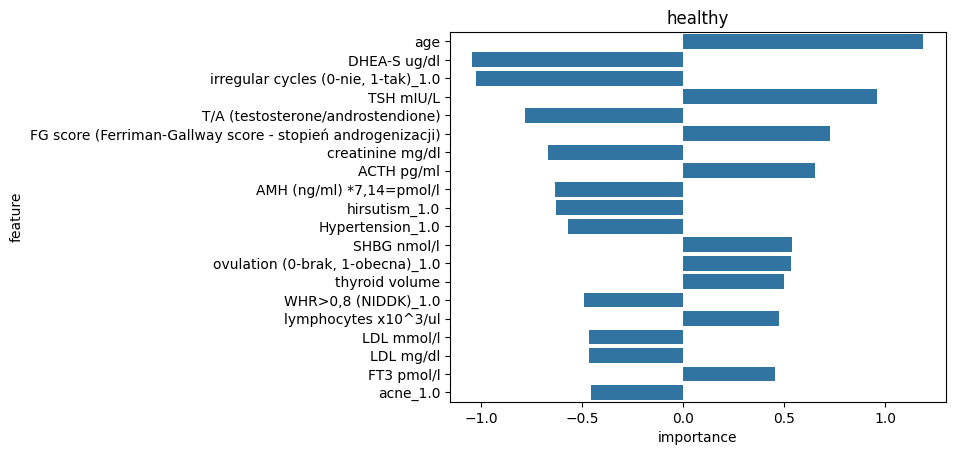

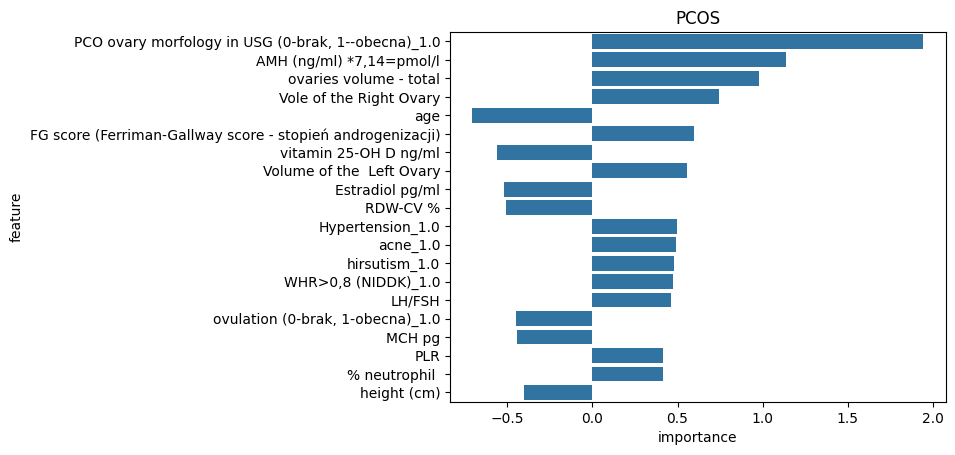

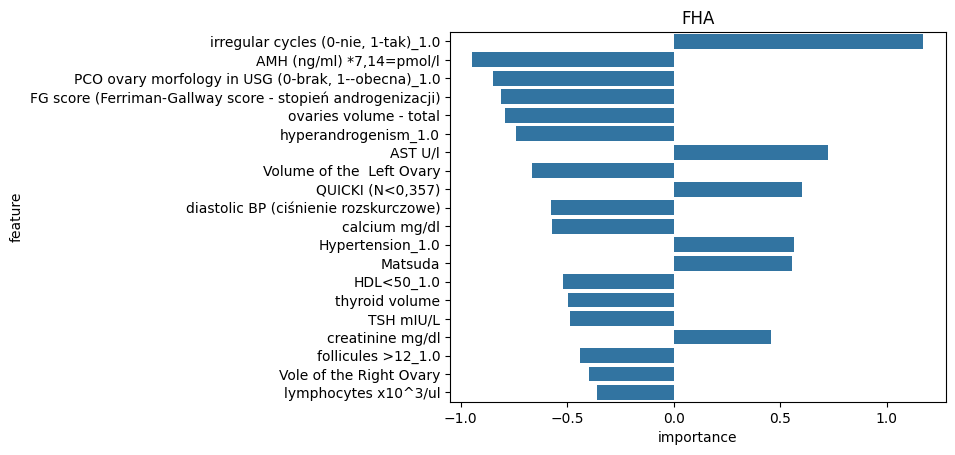

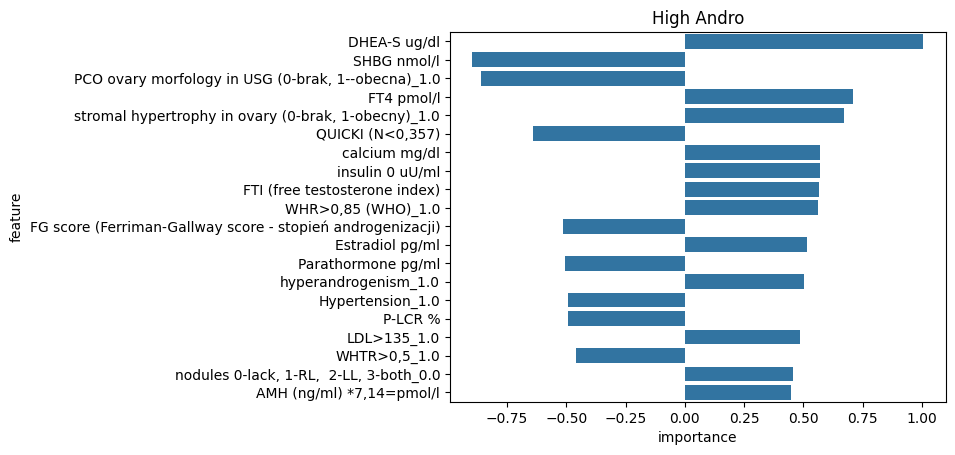

In [16]:
model_lr = LogisticRegression(C=0.5, multi_class='multinomial', max_iter=100000, n_jobs=-1)

feature_importnces_lr, pipeline_tlr = validate_model(model_lr, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor, categorical_preprocessor, get_feature_importance_logistic_regressison)

In [17]:
feature_importnces_lr.head(5)

feature    importance
132                                       sodium mmol/l -1.623701e-15
87                                   WHR>0,85 (WHO)_1.0  1.332268e-15
57   PCO ovary morfology in USG (0-brak, 1--obecna)_1.0  1.221245e-15
114                 irregular cycles (0-nie, 1-tak)_1.0 -1.144917e-15
127                    ovulation (0-brak, 1-obecna)_1.0 -1.113692e-15

In [18]:
rename_importnace_col(feature_importnces_lr, 'logistic regression')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'random forest')

feature_importance_df = merge_feature_importances([feature_importnces_lr, feature_importnces_tree, feature_importnces_rf])
ranked_df = rank_importances(feature_importance_df)

ranked_df_sorted = ranked_df.sort_values(by='average_rank')
ranked_df_sorted.head(15)

feature  logistic regression_importance  tree_importance  random forest_importance  average_rank
57           PCO ovary morfology in USG (0-brak, 1--obecna)_1.0                             3.0              1.0                       1.0          1.67
114                         irregular cycles (0-nie, 1-tak)_1.0                             4.0              2.0                       8.0          4.67
23                                                 DHEA-S ug/dl                            13.0              9.0                       6.0          9.33
12                                         Androstendione ng/ml                            17.0              4.0                      21.0         14.00
68                            T/A (testosterone/androstendione)                            10.0              6.0                      28.0         14.67
127                            ovulation (0-brak, 1-obecna)_1.0                             5.0             25.0                      22.0         17.33
123                                      ovaries volume - total                            24.0             25.0                       3.0         17.33
27   FG score (Ferriman-Gallway score - stopień androgenizacji)                            30.0              3.0                      19.0         17.33
111                                        hyperandrogenism_1.0                            19.0             25.0                      14.0         19.33
29                                                   FT3 pmol/l                            26.0             21.0                      12.0         19.67
133         stromal hypertrophy in ovary (0-brak, 1-obecny)_1.0                            13.0             25.0                      32.0         23.33
69                                                       T/SHBG                            36.0             25.0                       9.0         23.33
131                                                   prolactin                            32.0             25.0                      15.0         24.00
10                                     AMH (ng/ml) *7,14=pmol/l                            50.0             15.0                      10.0         25.00
100                       diastolic BP (ciśnienie rozskurczowe)                            17.0             25.0                      35.0         25.67

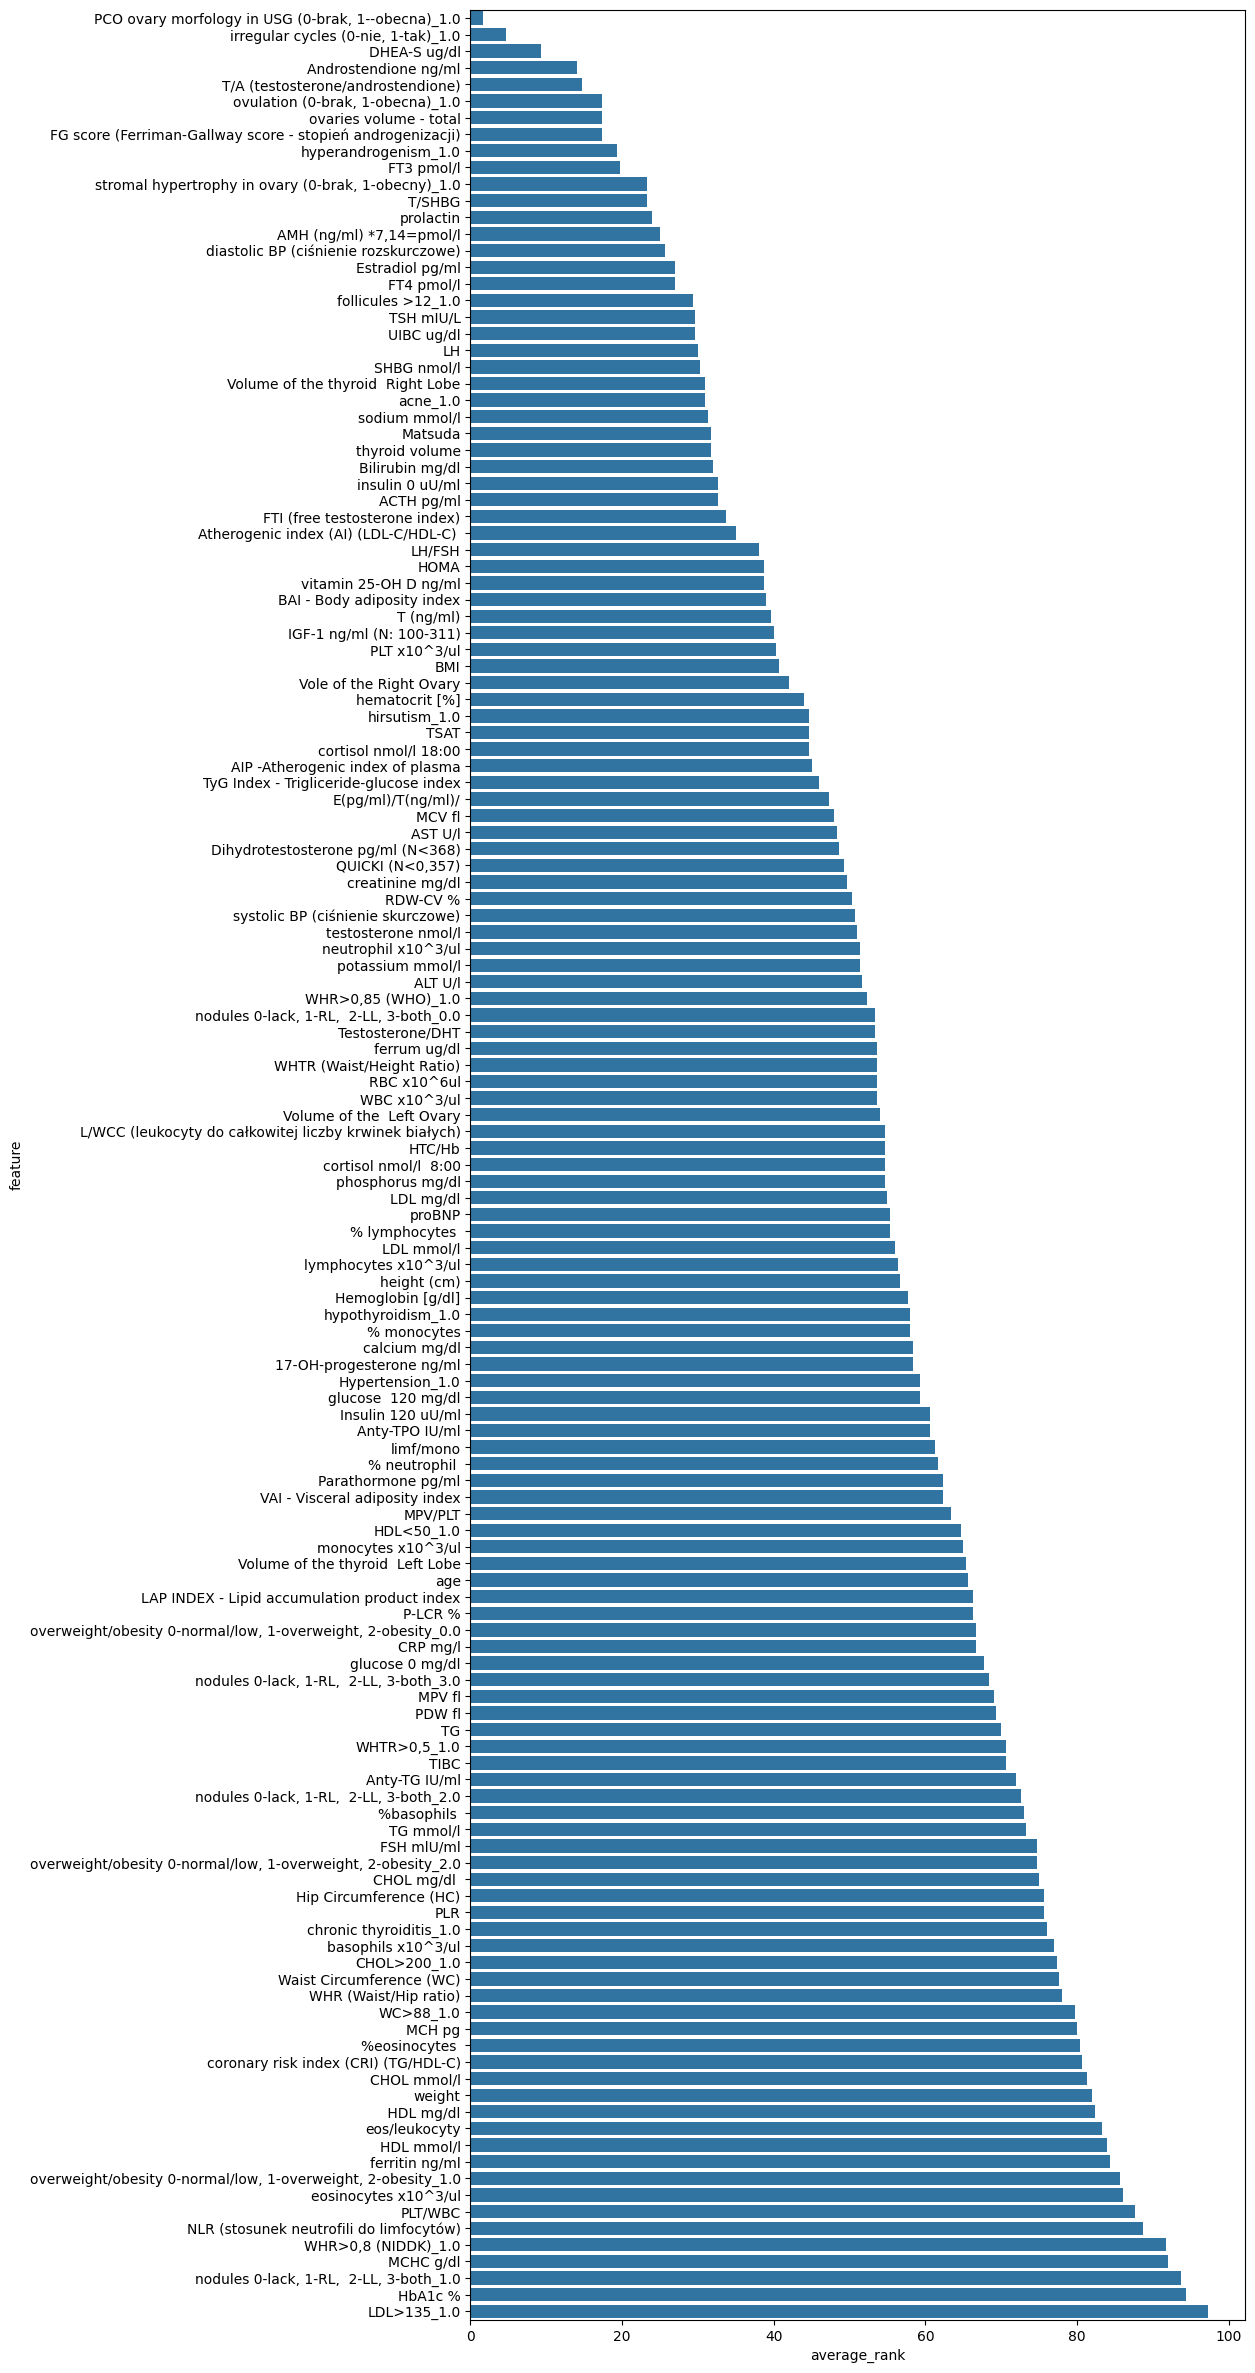

In [20]:
plt.figure(figsize=(10, 30))
sns.barplot(ranked_df_sorted, x="average_rank", y="feature")
plt.show()

## Feature selection

In [21]:
def feature_selection_chi2(feature_selection_model, X_train, y_train):
    preprocessor = ColumnTransformer(
        verbose_feature_names_out=False,
        transformers=[
            ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
            ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
        ])
    pipeline = Pipeline([('preprocessor', preprocessor), ('feature_selection', feature_selection_model)])

    X_new = pipeline.fit_transform(X_train, y_train)

    feature_importances = dict(zip(preprocessor.get_feature_names_out(), feature_selection_model.pvalues_))
    sorted_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=False)
    df_importances = pd.DataFrame(sorted_importances, columns=['feature', 'p_value'])


    selected_indices = feature_selection_model.get_support(indices=True)
    selected_feature_names = [preprocessor.get_feature_names_out()[i] for i in selected_indices]

    plt.figure(figsize=(10, 30))
    sns.barplot(df_importances, x="p_value", y="feature", legend=False)
    plt.show()

    return selected_feature_names

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


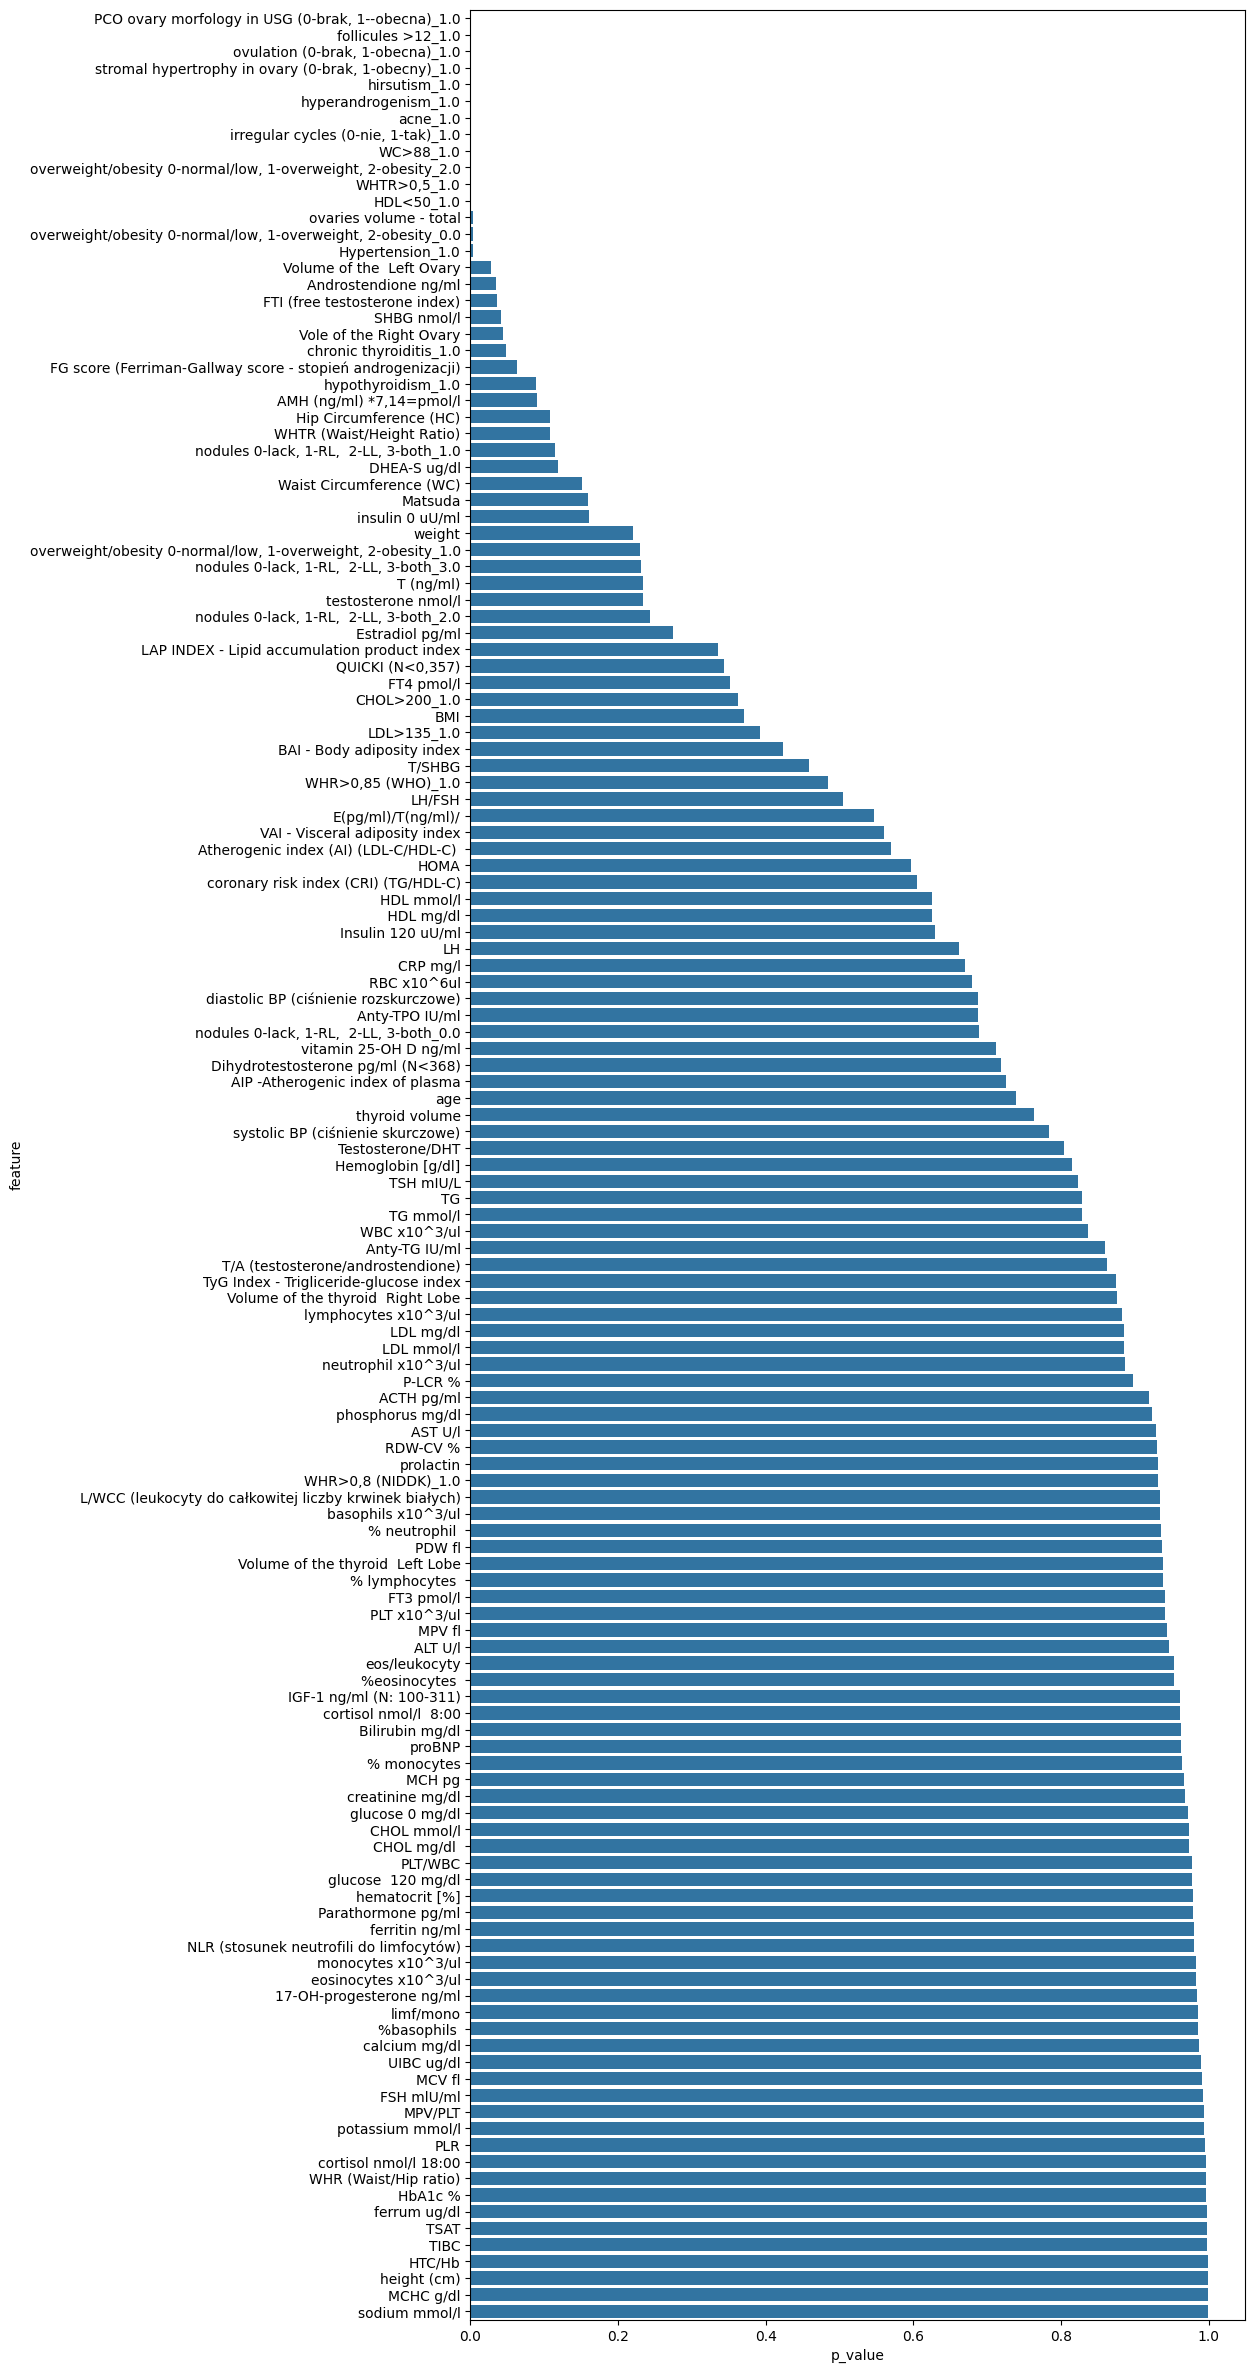

['ovaries volume - total',
 'Hypertension_1.0',
 'WC>88_1.0',
 'WHTR>0,5_1.0',
 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity_0.0',
 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity_2.0',
 'irregular cycles (0-nie, 1-tak)_1.0',
 'ovulation (0-brak, 1-obecna)_1.0',
 'PCO ovary morfology in USG (0-brak, 1--obecna)_1.0',
 'stromal hypertrophy in ovary (0-brak, 1-obecny)_1.0',
 'acne_1.0',
 'hirsutism_1.0',
 'hyperandrogenism_1.0',
 'follicules >12_1.0',
 'HDL<50_1.0']

In [22]:
selected_features_chi2 = feature_selection_chi2(SelectKBest(chi2, k=15), X_train, y_train)
selected_features_chi2

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


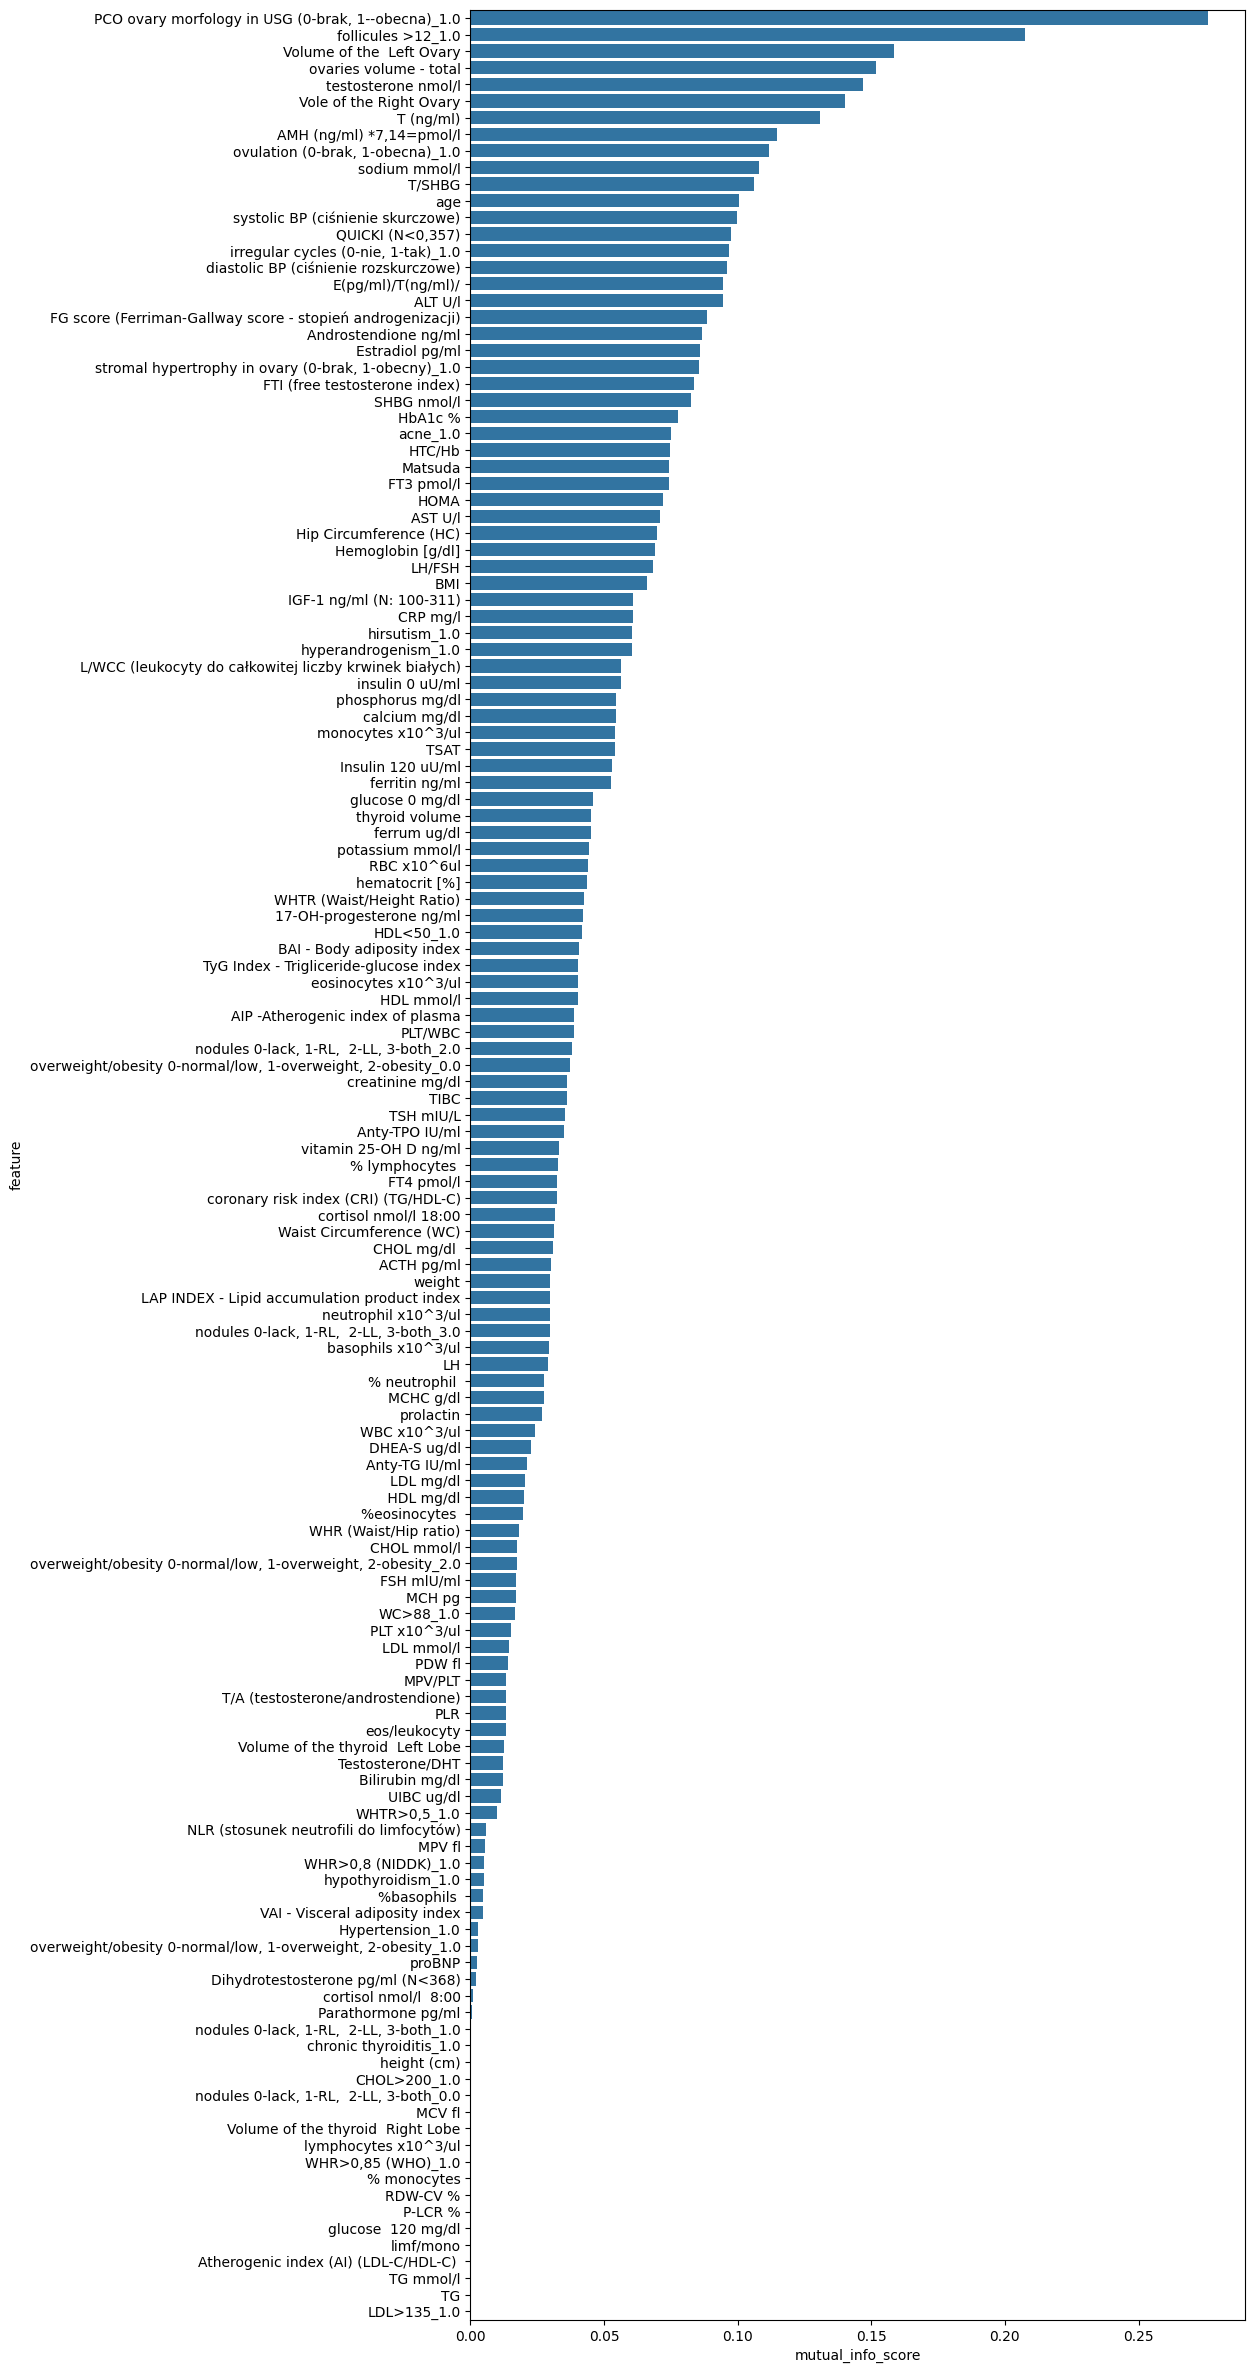

feature  mutual_info_score
0              PCO ovary morfology in USG (0-brak, 1--obecna)_1.0           0.276166
1                                              follicules >12_1.0           0.207607
2                                       Volume of the  Left Ovary           0.158664
3                                          ovaries volume - total           0.151602
4                                             testosterone nmol/l           0.146917
5                                         Vole of the Right Ovary           0.140339
6                                                       T (ng/ml)           0.130777
7                                        AMH (ng/ml) *7,14=pmol/l           0.114773
8                                ovulation (0-brak, 1-obecna)_1.0           0.111549
9                                                   sodium mmol/l           0.107943
10                                                         T/SHBG           0.106074
11                                                            age           0.100518
12                              systolic BP (ciśnienie skurczowe)           0.099817
13                                               QUICKI (N<0,357)           0.097577
14                            irregular cycles (0-nie, 1-tak)_1.0           0.096806
15                          diastolic BP (ciśnienie rozskurczowe)           0.095928
16                                             E(pg/ml)/T(ng/ml)/           0.094570
17                                                        ALT U/l           0.094400
18     FG score (Ferriman-Gallway score - stopień androgenizacji)           0.088363
19                                           Androstendione ng/ml           0.086750
20                                                Estradiol pg/ml           0.086074
21            stromal hypertrophy in ovary (0-brak, 1-obecny)_1.0           0.085384
22                                  FTI (free testosterone index)           0.083796
23                                                    SHBG nmol/l           0.082419
24                                                        HbA1c %           0.077817
25                                                       acne_1.0           0.075134
26                                                         HTC/Hb           0.074577
27                                                        Matsuda           0.074414
28                                                     FT3 pmol/l           0.074161
29                                                           HOMA           0.072156
30                                                        AST U/l           0.070822
31                                         Hip Circumference (HC)           0.069680
32                                              Hemoglobin [g/dl]           0.068969
33                                                         LH/FSH           0.068219
34                                                            BMI           0.065990
35                                       IGF-1 ng/ml (N: 100-311)           0.060835
36                                                       CRP mg/l           0.060686
37                                                  hirsutism_1.0           0.060475
38                                           hyperandrogenism_1.0           0.060411
39         L/WCC (leukocyty do całkowitej liczby krwinek białych)           0.056477
40                                                insulin 0 uU/ml           0.056267
41                                               phosphorus mg/dl           0.054633
42                                                  calcium mg/dl           0.054437
43                                             monocytes x10^3/ul           0.054231
44                                                           TSAT           0.054021
45                                              Insulin 120 uU/ml           0.053012
46                                                 ferritin ng/

In [31]:
def feature_selection_mutual_info(X_train, y_train):
    preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])

    pipeline = Pipeline([('preprocessor', preprocessor)])

    X_transformed = pipeline.fit_transform(X_train, y_train)

    mutual_info_scores = mutual_info_classif(X_transformed, y_train)
    feature_names = preprocessor.get_feature_names_out()

    feature_importances = pd.DataFrame({'feature': feature_names, 'mutual_info_score': mutual_info_scores})
    feature_importances_sorted = feature_importances.sort_values(by='mutual_info_score', key=abs, ascending=False)

    plt.figure(figsize=(10, 30))
    sns.barplot(feature_importances_sorted, x="mutual_info_score", y="feature", legend=False)
    plt.show()

    return feature_importances_sorted


selected_feature_names_mutual_info = feature_selection_mutual_info(X_train, y_train)
selected_feature_names_mutual_info = selected_feature_names_mutual_info[selected_feature_names_mutual_info['mutual_info_score'] > 0]
selected_feature_names_mutual_info.reset_index(drop=True, inplace=True)
selected_feature_names_mutual_info

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


Optimal number of features: 43
[ 5  1  1 53 65 11  1  1 67 29 15 30  1  4 18  1  1  1  1 56  7 52 36 69
 74 44 79 78 80 75 25 73 26 43  1 35 71 70 63 50 62 42 76 20 61 23 57 72
 46  1 33  1 28 58 60  1  1  1 47 68 54 41  8 37 51 49 45 55 14  1 17 40
 13  6 19 38 31 32 66 24  1 39  1  3  1  1  1  1 22 77 21  1  1  1  1  1
  1  1  1 10  1  1  1  1  1 34 64  1  1 12  1 16  1  9 93 94 86 84 85 91
 95 87  1  2  1 27 48 59  1 81 88 89 90 92 83  1 82 96 97]


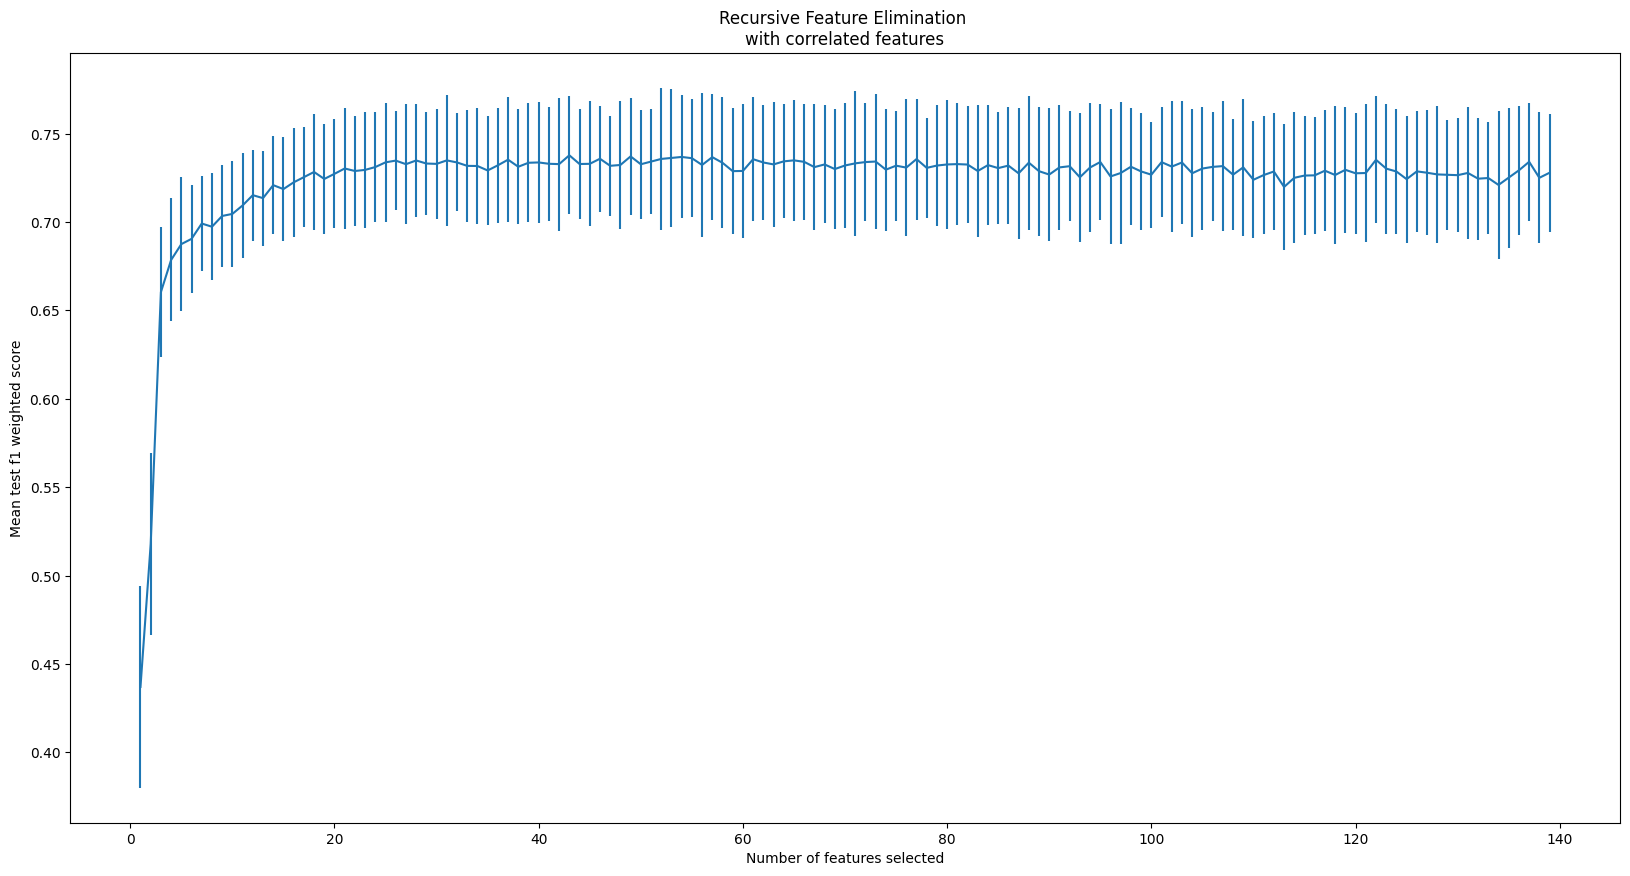

In [24]:
preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])


min_features_to_select = 1
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
rfecv = RFECV(
    estimator=RandomForestClassifier(min_samples_leaf=7, min_samples_split=5, class_weight='balanced_subsample'),
    step=1,
    cv=cv,
    scoring="f1_weighted",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

pipeline = Pipeline([('preprocessor', preprocessor), ('fs', rfecv)])
pipeline.fit(X_train, y_train)

selected_feature_indices = rfecv.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]

print(f"Optimal number of features: {rfecv.n_features_}")
print(rfecv.ranking_)


n_scores = len(rfecv.cv_results_["mean_test_score"])
scores = abs(rfecv.cv_results_["mean_test_score"])

plt.figure(figsize=(20,10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test f1 weighted score")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    scores,
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [30]:
print(len(rfecv.ranking_))

ranked_featrures_rfecv = pd.DataFrame({'features': preprocessor.get_feature_names_out(), 'ranking': rfecv.ranking_})
ranked_featrures_rfecv.sort_values(by='ranking').reset_index()

139


index                                                      features  ranking
0       69                                    BAI - Body adiposity index        1
1      100                                         cortisol nmol/l  8:00        1
2       98                                            E(pg/ml)/T(ng/ml)/        1
3       97                                                        T/SHBG        1
4       96                                                     T (ng/ml)        1
5       95                                           testosterone nmol/l        1
6       94                                                  DHEA-S ug/dl        1
7       93                                                     prolactin        1
8       92                                                        LH/FSH        1
9       91                                                            LH        1
10      87                                                    FT4 pmol/l        1
11      34                                                        MCV fl        1
12      86                                                    FT3 pmol/l        1
13      85                                                     TSH mIU/L        1
14      84                                              QUICKI (N<0,357)        1
15      82                                                          HOMA        1
16      80                                               insulin 0 uU/ml        1
17      57                                               Bilirubin mg/dl        1
18      56                                                       AST U/l        1
19      55                                                       ALT U/l        1
20     101                                         cortisol nmol/l 18:00        1
21      51                                                 calcium mg/dl        1
22     102                                               Estradiol pg/ml        1
23     104                                 FTI (free testosterone index)        1
24       1                                                        proBNP        1
25       2                                      AMH (ng/ml) *7,14=pmol/l        1
26     135                                            follicules >12_1.0        1
27     128                                          hyperandrogenism_1.0        1
28     124            PCO ovary morfology in USG (0-brak, 1--obecna)_1.0        1
29       6                             systolic BP (ciśnienie skurczowe)        1
30       7                         diastolic BP (ciśnienie rozskurczowe)        1
31     103                                                   SHBG nmol/l        1
32     112                             T/A (testosterone/androstendione)        1
33     122                           irregular cycles (0-nie, 1-tak)_1.0        1
34      12    FG score (Ferriman-Gallway score - stopień androgenizacji)        1
35     108                                          Androstendione ng/ml        1
36      15                                                thyroid volume        1
37      16                                       Vole of the Right Ovary        1
38      17                                     Volume of the  Left Ovary        1
39      18                                        ovaries volume - total        1
40     107                                         vitamin 25-OH D ng/ml        1
41     110                             Dihydrotestosterone pg/ml (N<368)        1
42      49                                                 sodium mmol/l        1
43     123                              ovulation (0-brak, 1-obecna)_1.0        2
44      83                                                       Matsuda        3
45      13                             Volume of the thyroid  Right Lobe        4
46       0                                      IGF-1 ng/ml (N: 100-311)        5
47      73                                                    UIBC ug

In [25]:
preprocessor = ColumnTransformer(
verbose_feature_names_out=False,
transformers=[
    ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
    ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
])

pipeline = Pipeline([('preprocessor', preprocessor)])

pipeline.set_output(transform='default')

X_train_transformed = pipeline.fit_transform(X_train, y_train)

scores = gini_index.gini_index(X_train_transformed, y_train.astype(int))

gini_index_scores = pd.DataFrame({'features':  preprocessor.get_feature_names_out(), 'gini_index': scores})
gini_index_scores.sort_values(by='gini_index').head(5)

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


features  gini_index
124  PCO ovary morfology in USG (0-brak, 1--obecna)_1.0    0.472646
0                              IGF-1 ng/ml (N: 100-311)    0.500000
88                                       Anty-TPO IU/ml    0.500000
89                                        Anty-TG IU/ml    0.500000
90                                           FSH mlU/ml    0.500000

# PCO vs healthy

In [26]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)

#  remove all except PCO and healthy
df.loc[(df[PCO] != 0) & (df[PCO] != 1), PCO] = np.nan

CLASS_NAMES = ['healthy', 'PCOS']

df_cleaned = df.dropna(subset=[PCO])

X, y = df_cleaned.drop(columns=[PCO]), df_cleaned[PCO]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## hyperparam tuning

### Decision tree

In [27]:
model_tree = DecisionTreeClassifier()
param_grid_tree = {
    'model__criterion': ['gini'],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [4, 5, 6],
    'model__min_samples_leaf': [3, 4, 5],
    'model__class_weight': [None],
}

tree_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_tree, continuous_preprocessor_tree, categorical_preprocessor, param_grid_tree, scoring_metric='f1_weighted')
tree_h_scores.sort_values(by='mean_test_score', ascending=False)

Fitting 15 folds for each of 27 candidates, totalling 405 fits
Best parameters: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}
Best score (f1_weighted): 0.7896103924622742


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


params  mean_train_score  mean_test_score
20  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}          0.933303         0.789610
9   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.899535         0.786060
21  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4}          0.929532         0.784444
11  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}          0.899279         0.784210
12  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4}          0.896394         0.784185
10  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}          0.899686         0.784109
19  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}          0.933505         0.783844
15  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.891971         0.783840
22  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.929556         0.782991
23  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.929725         0.782607
16  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.891926         0.782509
24  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.921605         0.782490
17  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.892601         0.780819
1   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}          0.851686         0.779328
13  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.896798         0.778703
2   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}          0.851686         0.778478
18  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.933672         0.778277
5   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.850850         0.777820
25  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.921250         0.777761
14  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.897031         0.777367
0   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.851686         0.777167
4   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.

### Logistic regression

Fitting 15 folds for each of 8 candidates, totalling 120 fits
Best parameters: {'model__C': 0.5}
Best score (f1_weighted): 0.8408034729630532


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


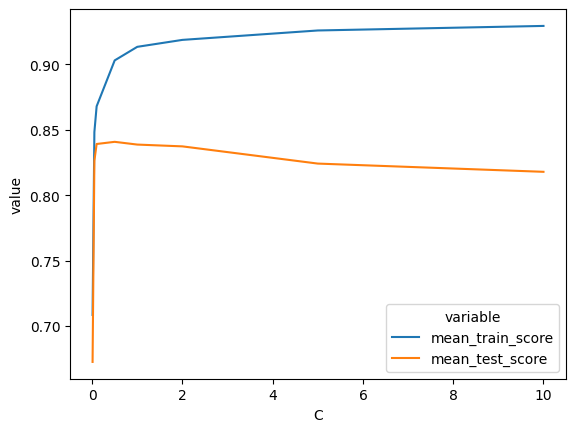

C  mean_train_score  mean_test_score
0  0.01          0.708395         0.672454
1  0.05          0.848266         0.826325
2   0.1          0.867987         0.839156
3   0.5          0.903094         0.840803
4     1          0.913467         0.838706
5     2          0.918782         0.837330
6     5          0.925980         0.824167
7    10          0.929464         0.817870

In [28]:
model_lr = LogisticRegression(multi_class='multinomial', max_iter=100000, n_jobs=-1)

param_grid_lr = {
    'model__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10],
}

lr_h_scores = hyperparameter_tuning_linear(X_train, y_train, PCO, model_lr, continuous_preprocessor, categorical_preprocessor, param_grid_lr, main_parameter='C', scoring_metric='f1_weighted')
lr_h_scores

Selected C=0.1

### Random forest

In [30]:
model_rf = RandomForestClassifier(n_jobs=-1)

param_grid_rf = {
    'model__criterion': ['gini'],
    'model__class_weight': ['balanced_subsample'],
    'model__n_estimators': [200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [3, 4, 5],
    'model__min_samples_leaf': [5, 6, 7],
}

rf_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_rf, continuous_preprocessor_tree, categorical_preprocessor, param_grid_rf, scoring_metric='f1_weighted')
rf_h_scores.sort_values(by='mean_test_score', ascending=False)

Fitting 15 folds for each of 9 candidates, totalling 135 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


Best parameters: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 3, 'model__n_estimators': 200}
Best score (f1_weighted): 0.8458740451925819


params  mean_train_score  mean_test_score
3  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.980046         0.845874
6  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.970216         0.844710
7  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.971201         0.843753
8  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.971363         0.843127
0  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.987352         0.842605
4  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.978069         0.842379
2  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.987209         0.839837
1  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.988335         0.839369
5  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.979331         0.839346

### SVC

In [34]:
model_svc = SVC(decision_function_shape='ovo')

param_grid_svc = {
    'model__kernel': ['linear', 'rbf', 'sigmoid'],
    'model__C': [0.1, 1, 10],
    'model__gamma': [0.1, 1, 10],
    # 'model__epsilon': [0.1, 0.2, 0.3],
}

svc_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_svc, continuous_preprocessor, categorical_preprocessor, param_grid_svc, scoring_metric='f1_weighted')
svc_h_scores.sort_values(by='mean_test_score', ascending=False)


Fitting 15 folds for each of 27 candidates, totalling 405 fits
Best parameters: {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best score (f1_weighted): 0.8576922036265995


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


params  mean_train_score  mean_test_score
19       {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}          0.999859         0.857692
10        {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}          0.926419         0.836453
15      {'model__C': 1, 'model__gamma': 10, 'model__kernel': 'linear'}          0.910784         0.832355
9      {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'linear'}          0.910784         0.832355
12       {'model__C': 1, 'model__gamma': 1, 'model__kernel': 'linear'}          0.910784         0.832355
0    {'model__C': 0.1, 'model__gamma': 0.1, 'model__kernel': 'linear'}          0.869790         0.826722
3      {'model__C': 0.1, 'model__gamma': 1, 'model__kernel': 'linear'}          0.869790         0.826722
6     {'model__C': 0.1, 'model__gamma': 10, 'model__kernel': 'linear'}          0.869790         0.826722
24     {'model__C': 10, 'model__gamma': 10, 'model__kernel': 'linear'}          0.936041         0.812839
21      {'model__C': 10, 'model__gamma': 1, 'model__kernel': 'linear'}          0.936041         0.812839
18    {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'linear'}          0.936041         0.812839
11    {'model__C': 1, 'model__gamma': 0.1, 'model__kernel': 'sigmoid'}          0.609072         0.608233
22         {'model__C': 10, 'model__gamma': 1, 'model__kernel': 'rbf'}          1.000000         0.594770
13          {'model__C': 1, 'model__gamma': 1, 'model__kernel': 'rbf'}          0.999719         0.581548
20   {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'sigmoid'}          0.587544         0.575110
14      {'model__C': 1, 'model__gamma': 1, 'model__kernel': 'sigmoid'}          0.571894         0.572647
1       {'model__C': 0.1, 'model__gamma': 0.1, 'model__kernel': 'rbf'}          0.571894         0.572647
16         {'model__C': 1, 'model__gamma': 10, 'model__kernel': 'rbf'}          1.000000         0.572647
17     {'model__C': 1, 'model__gamma': 10, 'model__kernel': 'sigmoid'}          0.571894         0.572647
8    {'model__C': 0.1, 'model__gamma': 10, 'model__kernel': 'sigmoid'}          0.571894         0.572647
7        {'model__C': 0.1, 'model__gamma': 10, 'model__kernel': 'rbf'}          0.571894         0.572647
5     {'model__C': 0.1, 'model__gamma': 1, 'model__kernel': 'sigmoid'}          0.571894         0.572647
4         {'model__C': 0.1, 'model__gamma': 1, 'model__kernel': 'rbf'}          0.571894         0.572647
23     {'model__C': 10, 'model__gamma': 1, 'model__kernel': 'sigmoid'}          0.571894         0.572647
2   {'model__C': 0.1, 'model__gamma': 0.1, 'model__kernel': 'sigmoid'}          0.571894         0.572647
25        {'model__C': 10, 'model__gamma': 10, 'model__kernel': 'rbf'}          1.000000         0.572647
26    {'model__C': 10, 'model__gamma': 10, 'model__kernel': 'sigmoid'}          0.571894         0.572647

## Best models

### Decision tree

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


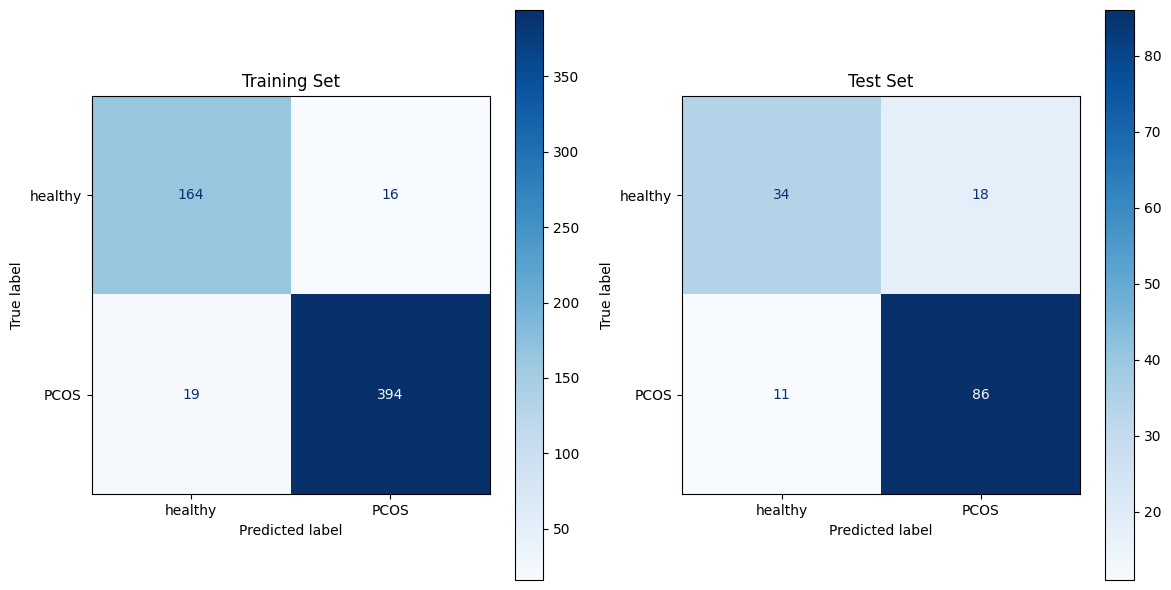

Training set
              precision    recall  f1-score   support

     healthy       0.90      0.91      0.90       180
        PCOS       0.96      0.95      0.96       413

    accuracy                           0.94       593
   macro avg       0.93      0.93      0.93       593
weighted avg       0.94      0.94      0.94       593

Test set
              precision    recall  f1-score   support

     healthy       0.76      0.65      0.70        52
        PCOS       0.83      0.89      0.86        97

    accuracy                           0.81       149
   macro avg       0.79      0.77      0.78       149
weighted avg       0.80      0.81      0.80       149



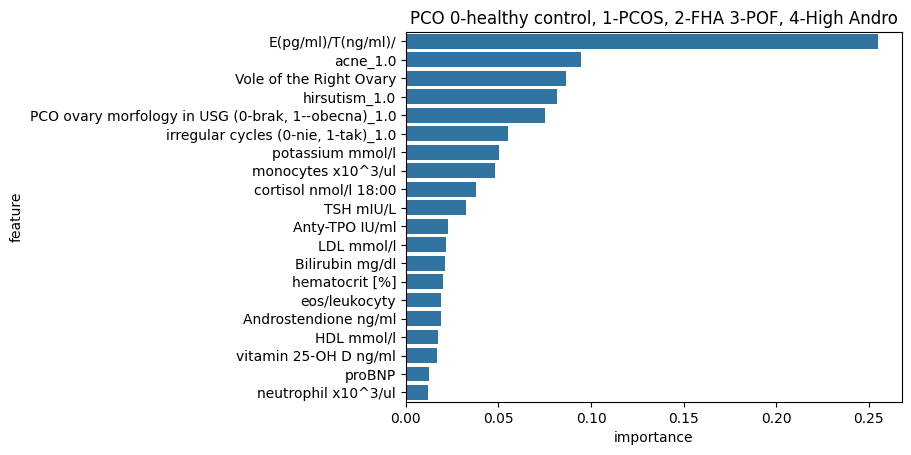

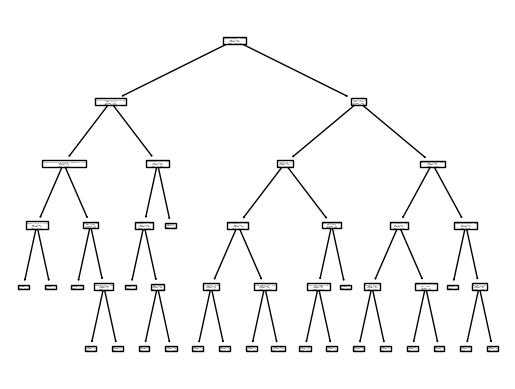

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


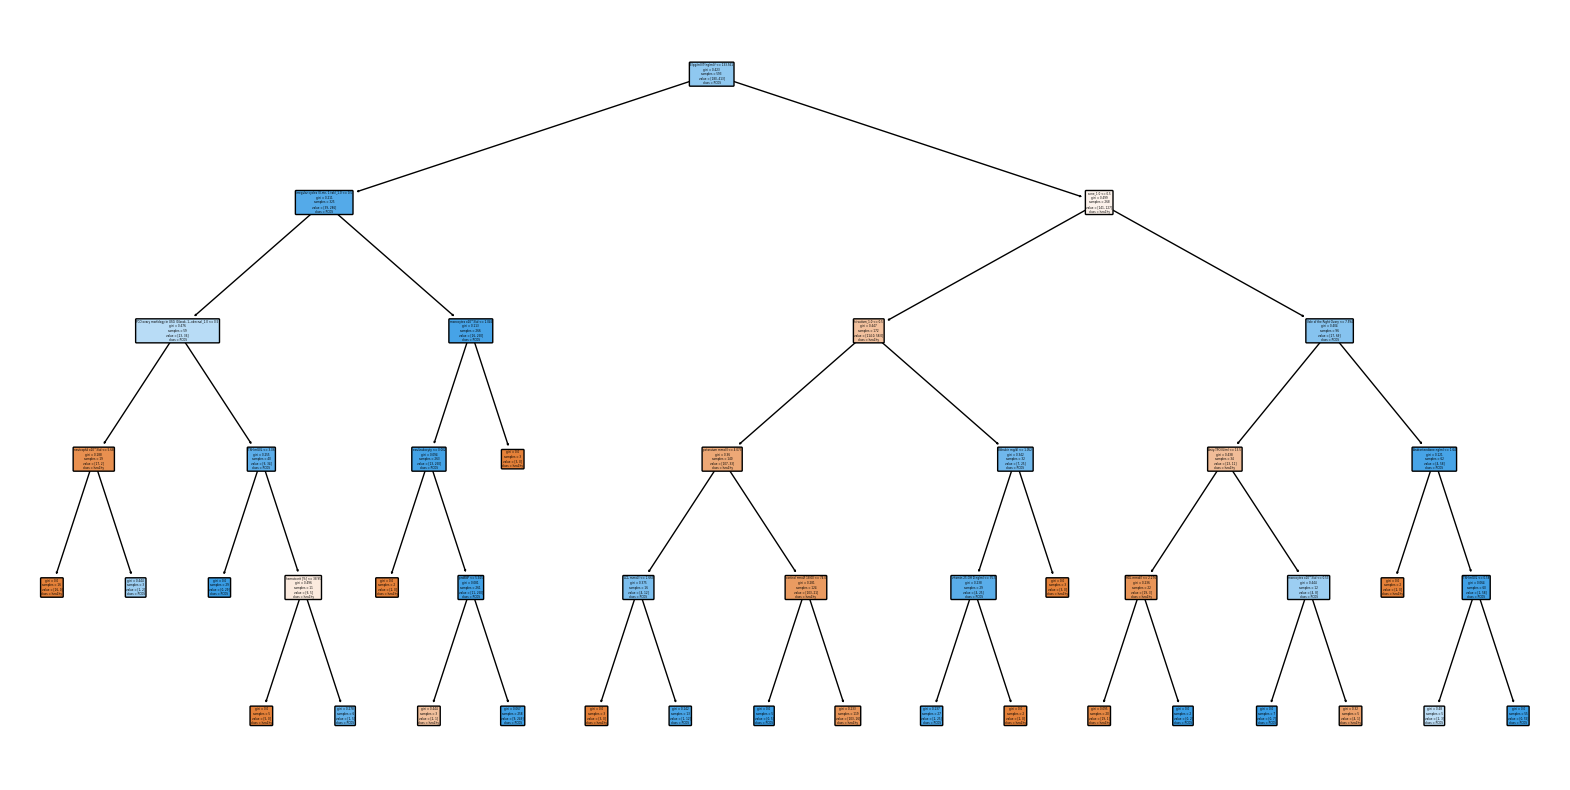

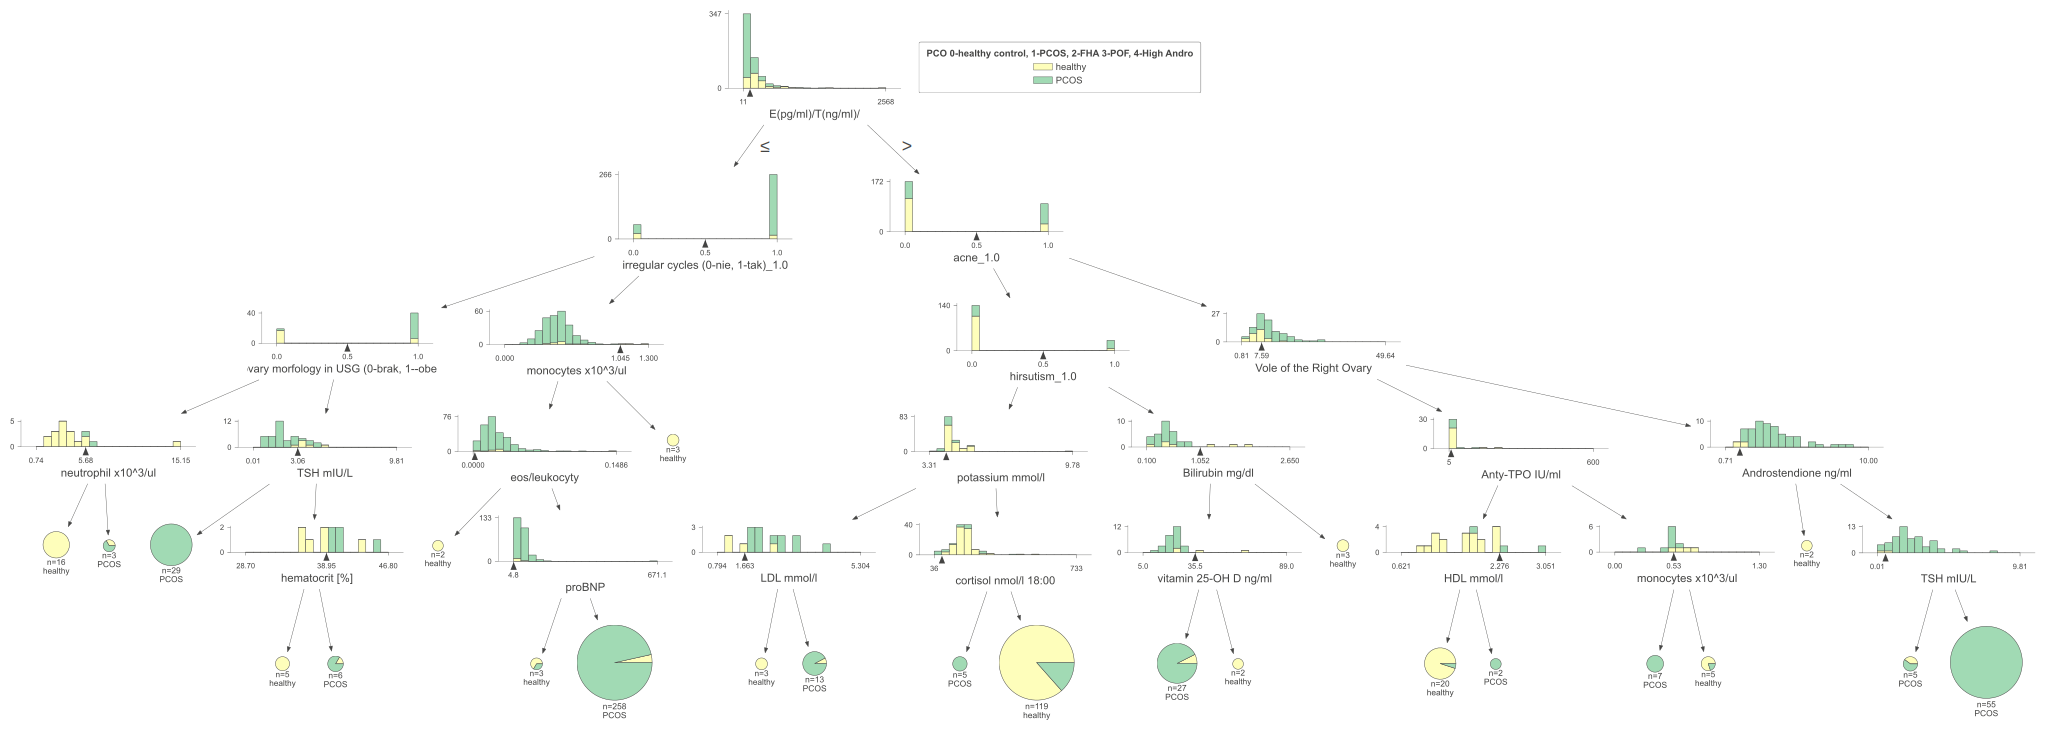

In [29]:
model_tree = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=2, min_samples_split=6, class_weight=None, random_state=7)
# {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}	

feature_importnces_tree, pipeline_tree = validate_model(model_tree, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor_tree, categorical_preprocessor, get_feature_importance_tree)

X_transformed = pipeline_tree['preprocessor'].fit_transform(X_train, y_train)
column_names = pipeline_tree['preprocessor'].get_feature_names_out()

plt.figure(figsize=(20,10))
plot_tree(pipeline_tree['model'], filled=True, rounded=True, feature_names=column_names, class_names=CLASS_NAMES)
plt.savefig('charts/trees/PCO_tree.pdf')
plt.show()

viz_model = dtreeviz.model(pipeline_tree['model'],
                        X_train=X_transformed,
                        y_train=y_train.astype(int),
                        feature_names=column_names,
                        target_name=PCO,
                        class_names=CLASS_NAMES,
                        )

viz_model.view(scale=1.8)

### RF

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


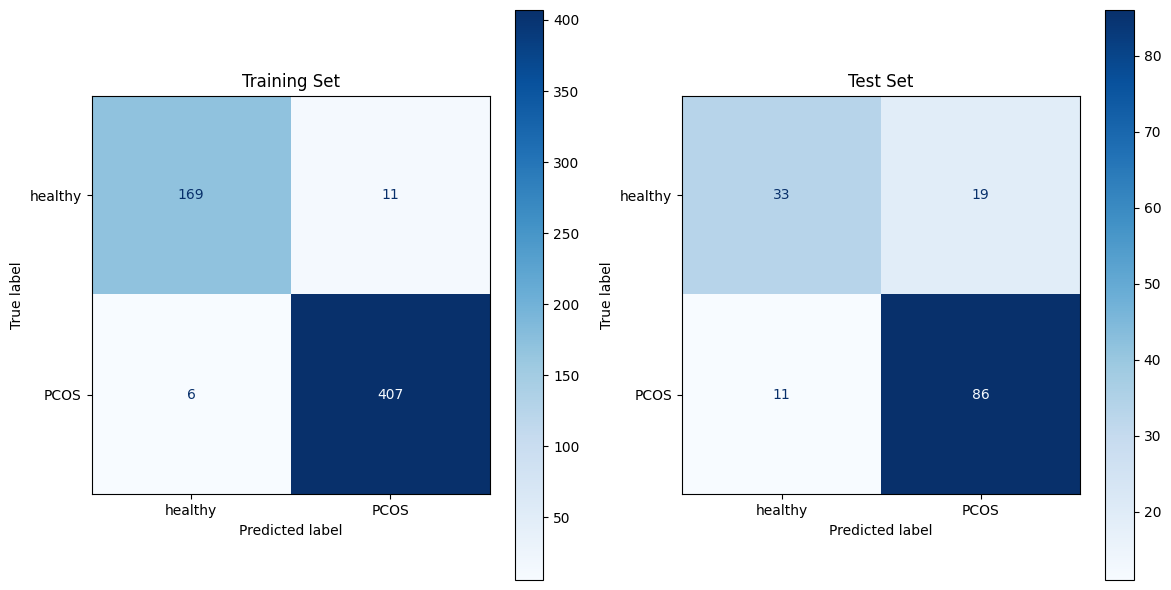

Training set
              precision    recall  f1-score   support

     healthy       0.97      0.94      0.95       180
        PCOS       0.97      0.99      0.98       413

    accuracy                           0.97       593
   macro avg       0.97      0.96      0.97       593
weighted avg       0.97      0.97      0.97       593

Test set
              precision    recall  f1-score   support

     healthy       0.75      0.63      0.69        52
        PCOS       0.82      0.89      0.85        97

    accuracy                           0.80       149
   macro avg       0.78      0.76      0.77       149
weighted avg       0.79      0.80      0.79       149



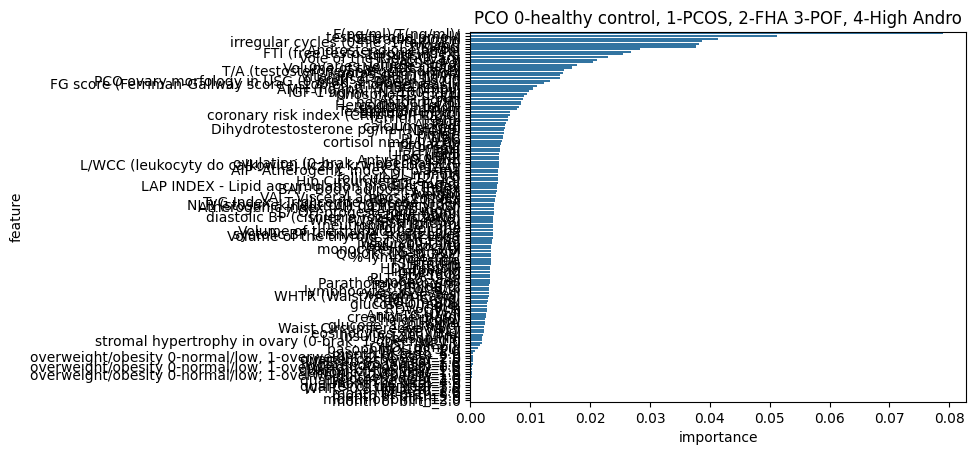

In [31]:
model_rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=5, class_weight='balanced_subsample', random_state=72)

feature_importnces_rf, pipeline_rf = validate_model(model_rf, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor_tree, categorical_preprocessor, get_feature_importance_rf)

### Logistic Regression

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


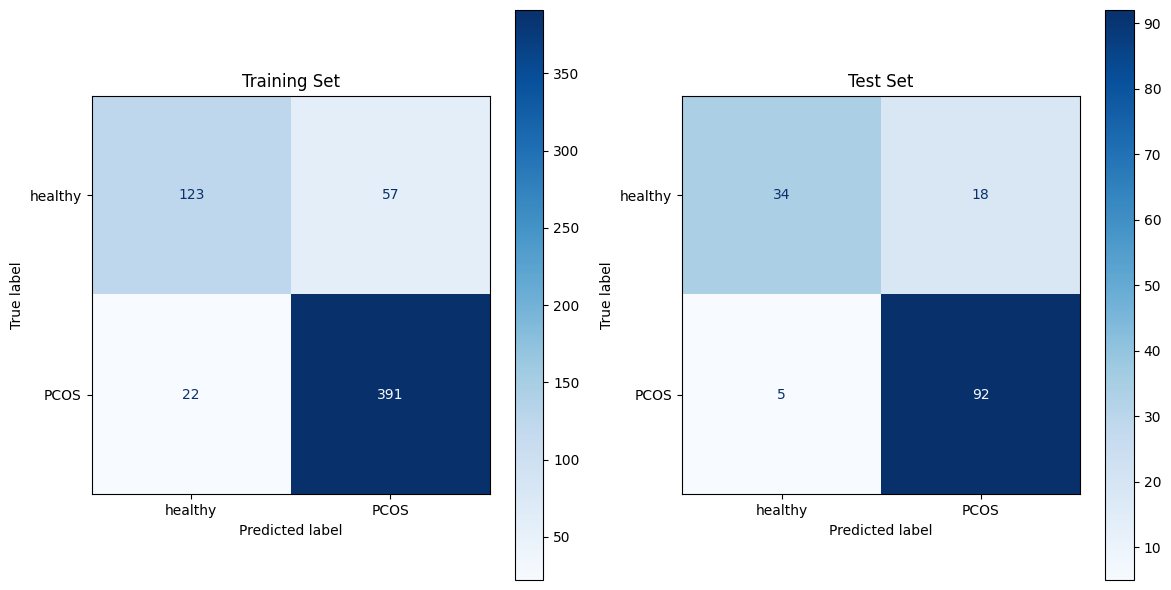

Training set
              precision    recall  f1-score   support

     healthy       0.85      0.68      0.76       180
        PCOS       0.87      0.95      0.91       413

    accuracy                           0.87       593
   macro avg       0.86      0.82      0.83       593
weighted avg       0.87      0.87      0.86       593

Test set
              precision    recall  f1-score   support

     healthy       0.87      0.65      0.75        52
        PCOS       0.84      0.95      0.89        97

    accuracy                           0.85       149
   macro avg       0.85      0.80      0.82       149
weighted avg       0.85      0.85      0.84       149



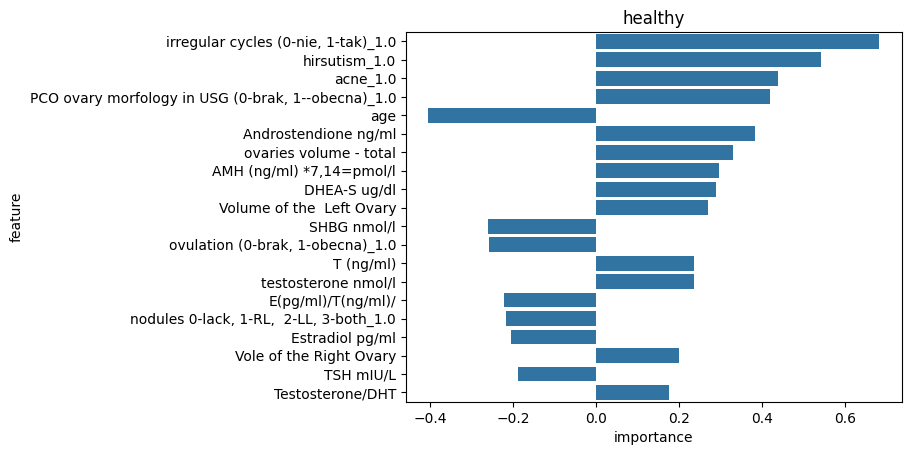

In [35]:
model_lr = LogisticRegression(C=0.1, multi_class='multinomial', max_iter=100000, n_jobs=-1)

feature_importnces_lr, pipeline_tlr = validate_model(model_lr, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor, categorical_preprocessor, get_feature_importance_logistic_regressison)

# FHA vs healthy

In [36]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

 
df.loc[(df[PCO] != 0) & (df[PCO] != 2), PCO] = np.nan

#  change all 2s to 1s for the need of the visualisation algorithm
df[PCO] = np.where(df[PCO] == 2, 1, df[PCO])

CLASS_NAMES = ['healthy', 'FHA']

df_cleaned = df.dropna(subset=[PCO])

X, y = df_cleaned.drop(columns=[PCO]), df_cleaned[PCO]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
model_tree = DecisionTreeClassifier()
param_grid_tree = {
    'model__criterion': ['gini'],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [4, 5, 6],
    'model__min_samples_leaf': [2, 3, 4],
    'model__class_weight': [None],
}

tree_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_tree, continuous_preprocessor_tree, categorical_preprocessor, param_grid_tree, scoring_metric='f1_weighted')
tree_h_scores.sort_values(by='mean_test_score', ascending=False)

Fitting 15 folds for each of 27 candidates, totalling 405 fits
Best parameters: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}
Best score (f1_weighted): 0.7478773049480797


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


params  mean_train_score  mean_test_score
0   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.865951         0.747877
2   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}          0.866920         0.747832
1   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}          0.866632         0.744371
8   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.858836         0.741460
24  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.927696         0.741142
6   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.858836         0.739372
7   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.858836         0.739309
26  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.927687         0.738907
5   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.860707         0.738558
3   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4}          0.860707         0.737472
4   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.861047         0.737423
18  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.951389         0.737134
22  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.939312         0.731322
16  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.901976         0.730182
25  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.927960         0.727270
23  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.939026         0.726973
15  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.901956         0.726530
19  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}          0.950028         0.726108
17  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.901976         0.725919
21  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4}          0.939885         0.724221
12  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4}          0.909326         0.723536
13  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.

Fitting 15 folds for each of 8 candidates, totalling 120 fits
Best parameters: {'model__C': 1}
Best score (f1_weighted): 0.7623292342087826


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


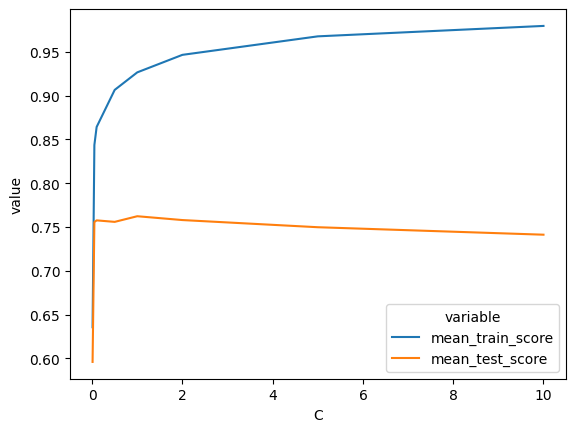

C  mean_train_score  mean_test_score
0  0.01          0.635667         0.596074
1  0.05          0.843607         0.755658
2   0.1          0.864177         0.757599
3   0.5          0.906481         0.755891
4     1          0.926494         0.762329
5     2          0.946482         0.757960
6     5          0.967596         0.749783
7    10          0.979495         0.741260

In [38]:
model_lr = LogisticRegression(multi_class='multinomial', max_iter=100000, n_jobs=-1)

param_grid_lr = {
    'model__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10],
}

lr_h_scores = hyperparameter_tuning_linear(X_train, y_train, PCO, model_lr, continuous_preprocessor, categorical_preprocessor, param_grid_lr, main_parameter='C', scoring_metric='f1_weighted')
lr_h_scores

C=0.05

In [39]:
model_rf = RandomForestClassifier(n_jobs=-1)

param_grid_rf = {
    'model__criterion': ['gini'],
    'model__class_weight': ['balanced_subsample'],
    'model__n_estimators': [200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [3, 4, 5],
    'model__min_samples_leaf': [5, 6, 7],
}

rf_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_rf, continuous_preprocessor_tree, categorical_preprocessor, param_grid_rf, scoring_metric='f1_weighted')
rf_h_scores.sort_values(by='mean_test_score', ascending=False)

Fitting 15 folds for each of 9 candidates, totalling 135 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


Best parameters: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 4, 'model__n_estimators': 200}
Best score (f1_weighted): 0.82374749201541


params  mean_train_score  mean_test_score
7  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.984764         0.823747
8  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.985327         0.823208
1  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.993079         0.816994
2  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.994188         0.814843
5  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.990585         0.813824
6  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.982547         0.807532
0  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.992804         0.807110
3  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.990308         0.800648
4  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.989475         0.799704

In [ ]:
# model_svc = SVC(n_jobs=-1, decision_function_shape='ovo')

# param_grid_svc = {
#     'model__kernel': ['linear', 'rbf', 'sigmoid'],
#     'model__C': [0.1, 1, 10, 100],
#     'model__gamma': [0.1, 1, 10],
#     'model__epsilon': [0.1, 0.2, 0.3],
# }

# svc_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_svc, continuous_preprocessor, categorical_preprocessor, param_grid_svc, scoring_metric='f1_weighted')
# svc_h_scores.sort_values(by='mean_test_score', ascending=False)

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


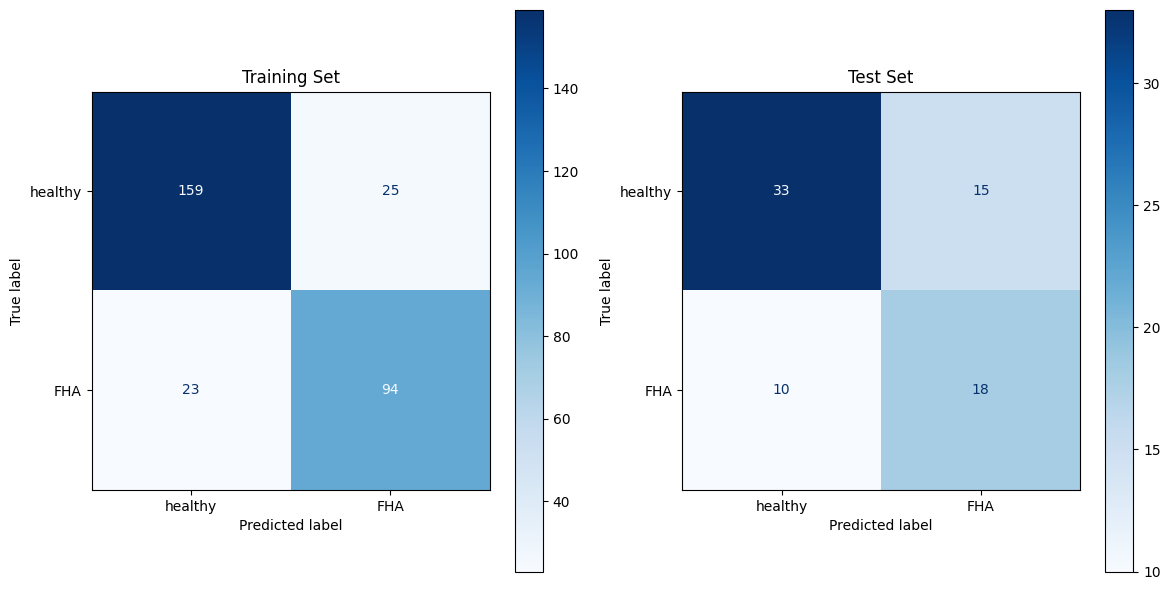

Training set
              precision    recall  f1-score   support

     healthy       0.87      0.86      0.87       184
         FHA       0.79      0.80      0.80       117

    accuracy                           0.84       301
   macro avg       0.83      0.83      0.83       301
weighted avg       0.84      0.84      0.84       301

Test set
              precision    recall  f1-score   support

     healthy       0.77      0.69      0.73        48
         FHA       0.55      0.64      0.59        28

    accuracy                           0.67        76
   macro avg       0.66      0.67      0.66        76
weighted avg       0.69      0.67      0.68        76



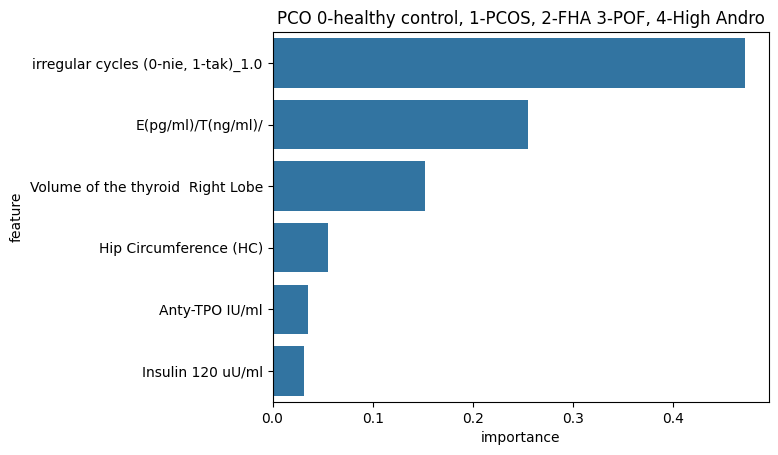

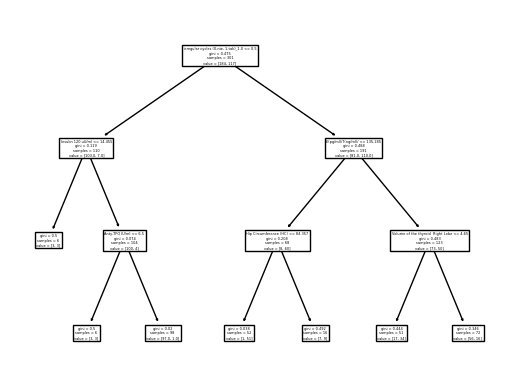

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


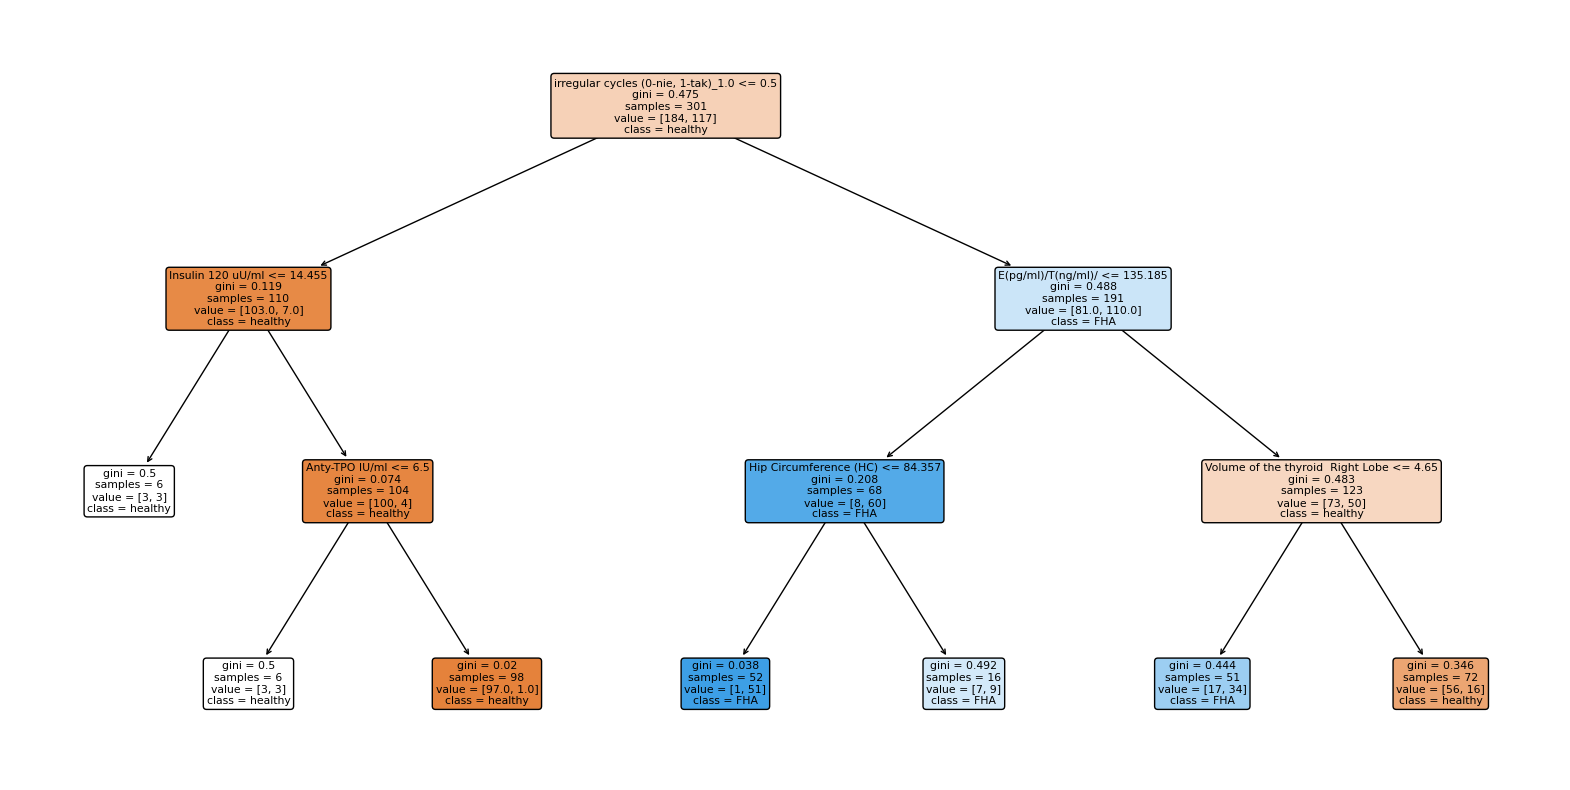

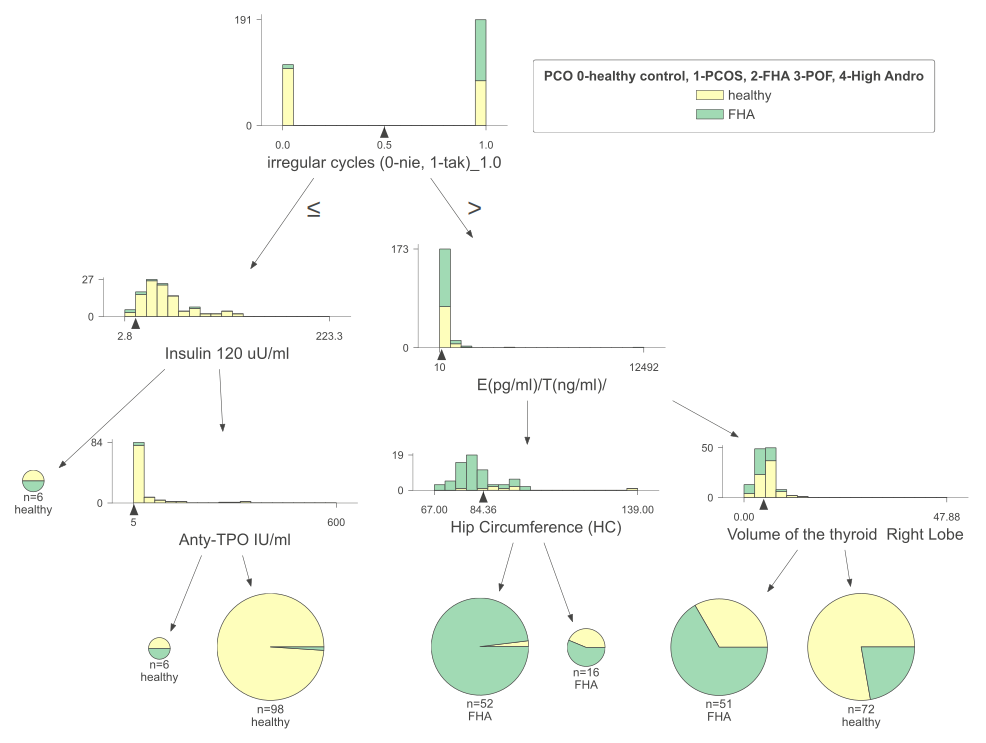

In [40]:
model_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=4, min_samples_split=6, class_weight=None, random_state=7)
# {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}	
feature_importnces_tree, pipeline_tree = validate_model(model_tree, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor_tree, categorical_preprocessor, get_feature_importance_tree)

X_transformed = pipeline_tree['preprocessor'].fit_transform(X_train, y_train)
column_names = pipeline_tree['preprocessor'].get_feature_names_out()

plt.figure(figsize=(20,10))
plot_tree(pipeline_tree['model'], filled=True, rounded=True, feature_names=column_names, class_names=CLASS_NAMES)
plt.savefig('charts/trees/PCO_tree.pdf')
plt.show()

viz_model = dtreeviz.model(pipeline_tree['model'],
                        X_train=X_transformed,
                        y_train=y_train.astype(int),
                        feature_names=column_names,
                        target_name=PCO,
                        class_names=CLASS_NAMES,
                        )

viz_model.view(scale=1.8)

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


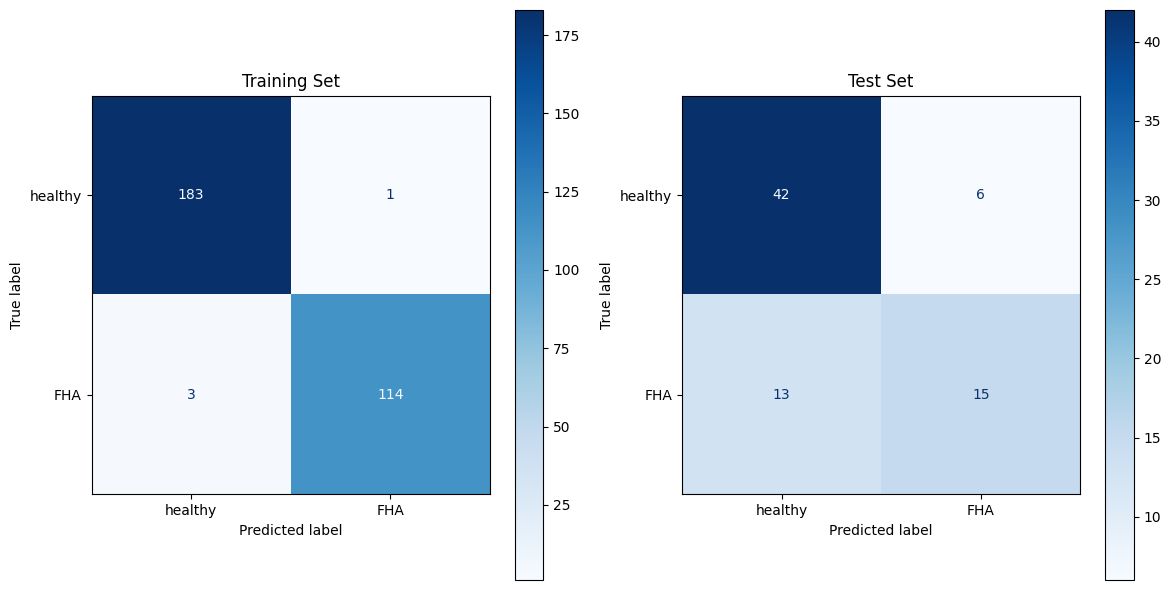

Training set
              precision    recall  f1-score   support

     healthy       0.98      0.99      0.99       184
         FHA       0.99      0.97      0.98       117

    accuracy                           0.99       301
   macro avg       0.99      0.98      0.99       301
weighted avg       0.99      0.99      0.99       301

Test set
              precision    recall  f1-score   support

     healthy       0.76      0.88      0.82        48
         FHA       0.71      0.54      0.61        28

    accuracy                           0.75        76
   macro avg       0.74      0.71      0.71        76
weighted avg       0.75      0.75      0.74        76



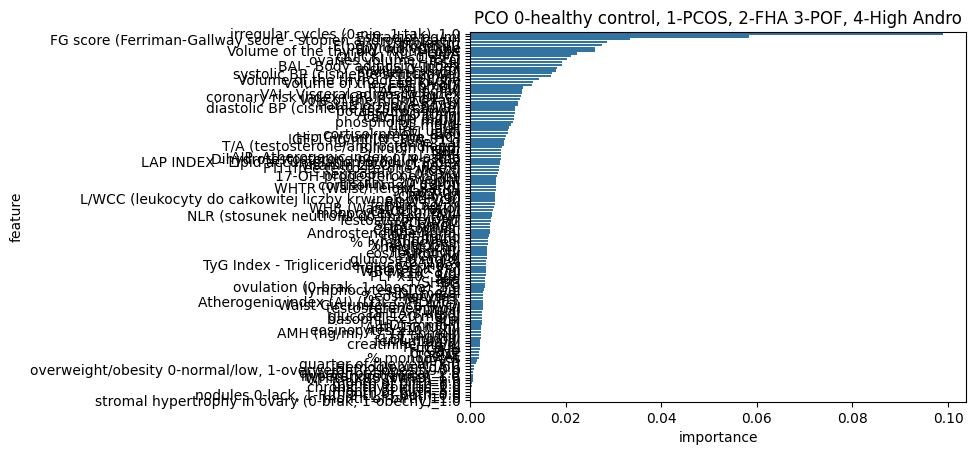

In [43]:
model_rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=5, class_weight='balanced_subsample', random_state=72)

feature_importnces_rf, pipeline_rf = validate_model(model_rf, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor_tree, categorical_preprocessor, get_feature_importance_rf)

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


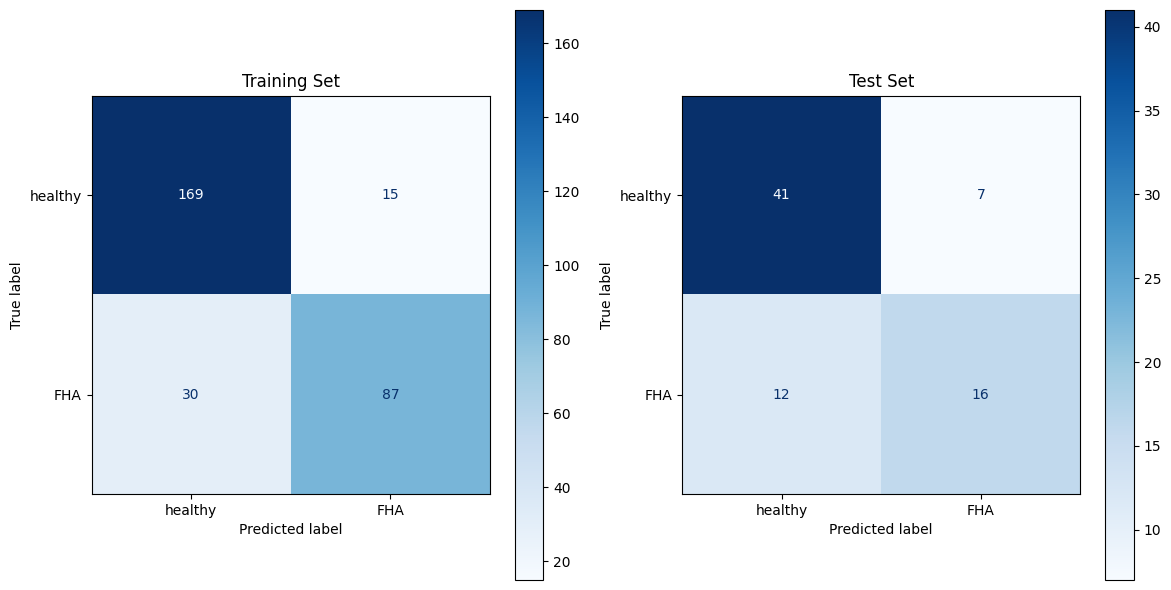

Training set
              precision    recall  f1-score   support

     healthy       0.85      0.92      0.88       184
         FHA       0.85      0.74      0.79       117

    accuracy                           0.85       301
   macro avg       0.85      0.83      0.84       301
weighted avg       0.85      0.85      0.85       301

Test set
              precision    recall  f1-score   support

     healthy       0.77      0.85      0.81        48
         FHA       0.70      0.57      0.63        28

    accuracy                           0.75        76
   macro avg       0.73      0.71      0.72        76
weighted avg       0.74      0.75      0.74        76



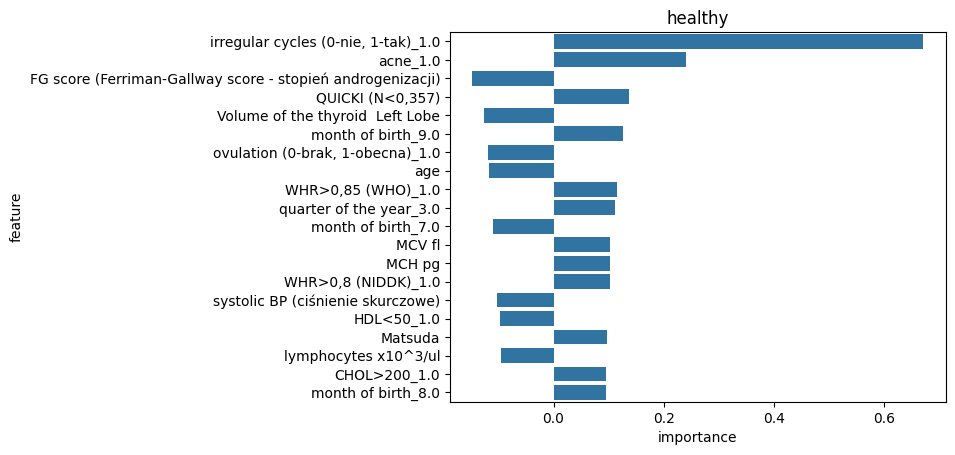

In [42]:
model_lr = LogisticRegression(C=0.05, multi_class='multinomial', max_iter=100000, n_jobs=-1)

feature_importnces_lr, pipeline_tlr = validate_model(model_lr, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor, categorical_preprocessor, get_feature_importance_logistic_regressison)

# High Andro vs healthy

In [44]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)

df.loc[(df[PCO] != 0) & (df[PCO] != 4), PCO] = np.nan

#  change all 4s to 1s for the need of the visualisation algorithm
df[PCO] = np.where(df[PCO] == 4, 1, df[PCO])

CLASS_NAMES = ['healthy', 'High Andro']

df_cleaned = df.dropna(subset=[PCO])

X, y = df_cleaned.drop(columns=[PCO]), df_cleaned[PCO]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
model_tree = DecisionTreeClassifier()
param_grid_tree = {
    'model__criterion': ['gini'],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [4, 5, 6],
    'model__min_samples_leaf': [2, 3, 4],
    'model__class_weight': [None],
}

tree_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_tree, continuous_preprocessor_tree, categorical_preprocessor, param_grid_tree, scoring_metric='f1_weighted')
tree_h_scores.sort_values(by='mean_test_score', ascending=False)

Fitting 15 folds for each of 27 candidates, totalling 405 fits
Best parameters: {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}
Best score (f1_weighted): 0.753558184282484


params  mean_train_score  mean_test_score
7   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.883589         0.753558
16  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.919113         0.749811
2   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 6}          0.890281         0.749616
6   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.883589         0.749094
1   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}          0.890281         0.747436
5   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.888746         0.746671
8   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.883589         0.743896
26  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.933823         0.743708
13  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.929065         0.743142
9   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.938314         0.741379
25  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5}          0.935556         0.740803
23  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.948613         0.740781
4   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.888746         0.739632
15  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 4}          0.919004         0.738167
3   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4}          0.888746         0.737565
0   {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.890281         0.737452
14  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 3, 'model__min_samples_split': 6}          0.928816         0.736490
22  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5}          0.950189         0.736221
17  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6}          0.918917         0.736170
10  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 4, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}          0.937898         0.733306
18  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4}          0.959821         0.731797
21  {'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4}          0.

Fitting 15 folds for each of 8 candidates, totalling 120 fits
Best parameters: {'model__C': 1}
Best score (f1_weighted): 0.8051008092132818


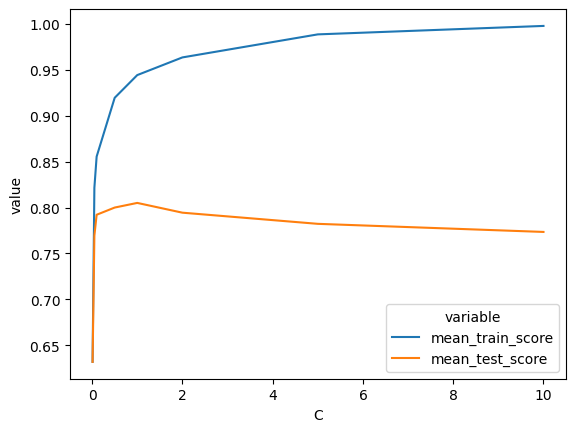

C  mean_train_score  mean_test_score
0  0.01          0.631861         0.631779
1  0.05          0.821635         0.769388
2   0.1          0.855601         0.792189
3   0.5          0.919691         0.800042
4     1          0.944443         0.805101
5     2          0.963699         0.794458
6     5          0.988813         0.782296
7    10          0.998030         0.773474

In [46]:
model_lr = LogisticRegression(multi_class='multinomial', max_iter=100000, n_jobs=-1)

param_grid_lr = {
    'model__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10],
}

lr_h_scores = hyperparameter_tuning_linear(X_train, y_train, PCO, model_lr, continuous_preprocessor, categorical_preprocessor, param_grid_lr, main_parameter='C', scoring_metric='f1_weighted')
lr_h_scores

C=0.1

In [47]:
model_rf = RandomForestClassifier(n_jobs=-1)

param_grid_rf = {
    'model__criterion': ['gini'],
    'model__class_weight': ['balanced_subsample'],
    'model__n_estimators': [200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [3, 4, 5],
    'model__min_samples_leaf': [5, 6, 7],
}

rf_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_rf, continuous_preprocessor_tree, categorical_preprocessor, param_grid_rf, scoring_metric='f1_weighted')
rf_h_scores.sort_values(by='mean_test_score', ascending=False)

Fitting 15 folds for each of 9 candidates, totalling 135 fits
Best parameters: {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best score (f1_weighted): 0.818980364280087


params  mean_train_score  mean_test_score
8  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.975478         0.818980
4  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.982974         0.816000
0  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.989185         0.811901
6  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.973178         0.811488
3  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 3, 'model__n_estimators': 200}          0.981674         0.811338
2  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.988856         0.810192
7  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.974525         0.810120
5  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 6, 'model__min_samples_split': 5, 'model__n_estimators': 200}          0.981024         0.808406
1  {'model__class_weight': 'balanced_subsample', 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 4, 'model__n_estimators': 200}          0.986892         0.802834

In [ ]:
# model_svc = SVC(n_jobs=-1, decision_function_shape='ovo')

# param_grid_svc = {
#     'model__kernel': ['linear', 'rbf', 'sigmoid'],
#     'model__C': [0.1, 1, 10, 100],
#     'model__gamma': [0.1, 1, 10],
#     'model__epsilon': [0.1, 0.2, 0.3],
# }

# svc_h_scores = hyperparameter_tuning_general(X_train, y_train, PCO, model_svc, continuous_preprocessor, categorical_preprocessor, param_grid_svc, scoring_metric='f1_weighted')
# svc_h_scores.sort_values(by='mean_test_score', ascending=False)

## Best models

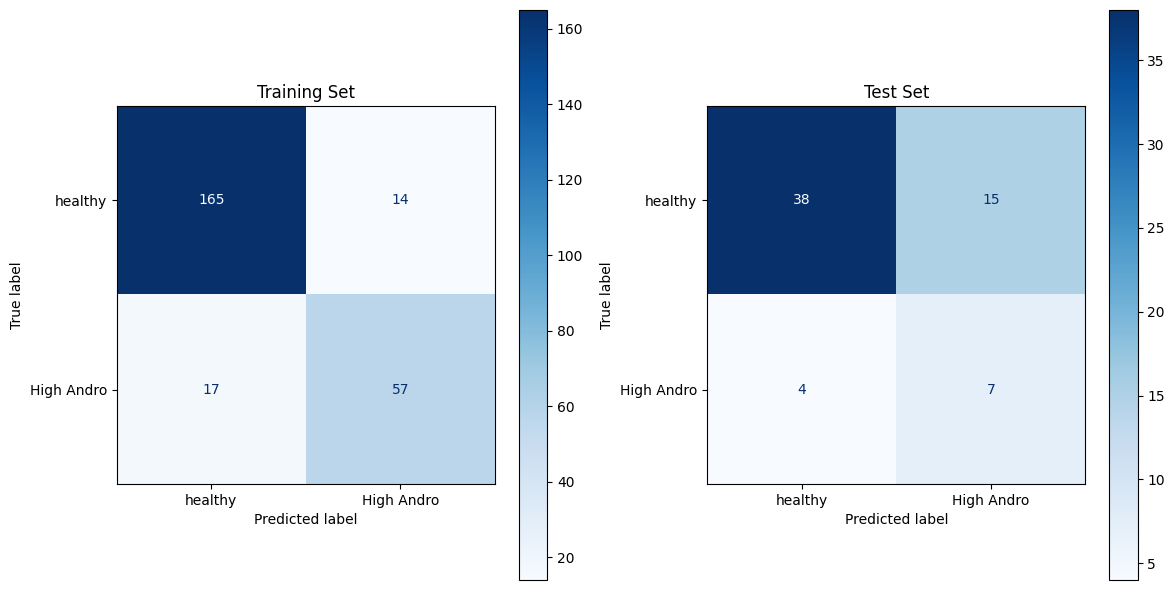

Training set
              precision    recall  f1-score   support

     healthy       0.91      0.92      0.91       179
  High Andro       0.80      0.77      0.79        74

    accuracy                           0.88       253
   macro avg       0.85      0.85      0.85       253
weighted avg       0.88      0.88      0.88       253

Test set
              precision    recall  f1-score   support

     healthy       0.90      0.72      0.80        53
  High Andro       0.32      0.64      0.42        11

    accuracy                           0.70        64
   macro avg       0.61      0.68      0.61        64
weighted avg       0.80      0.70      0.74        64



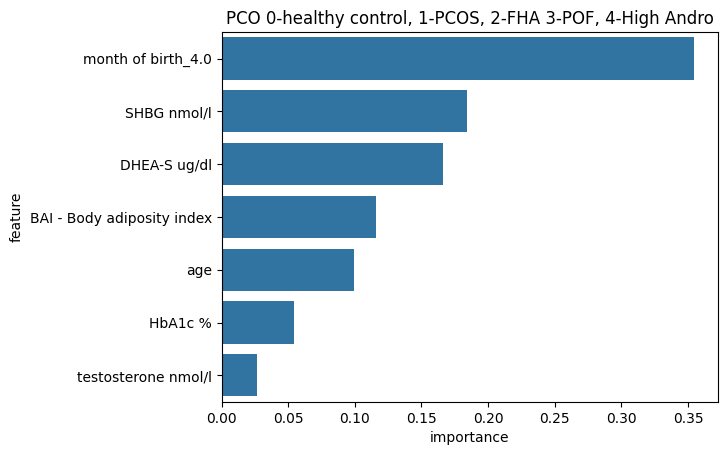

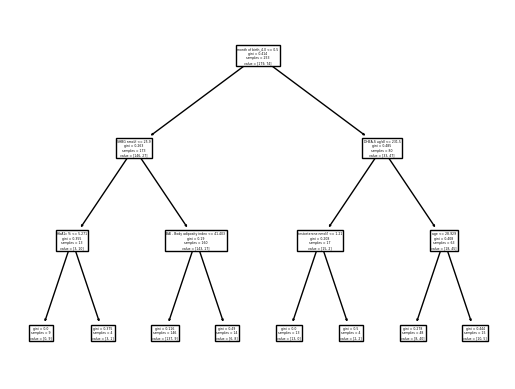

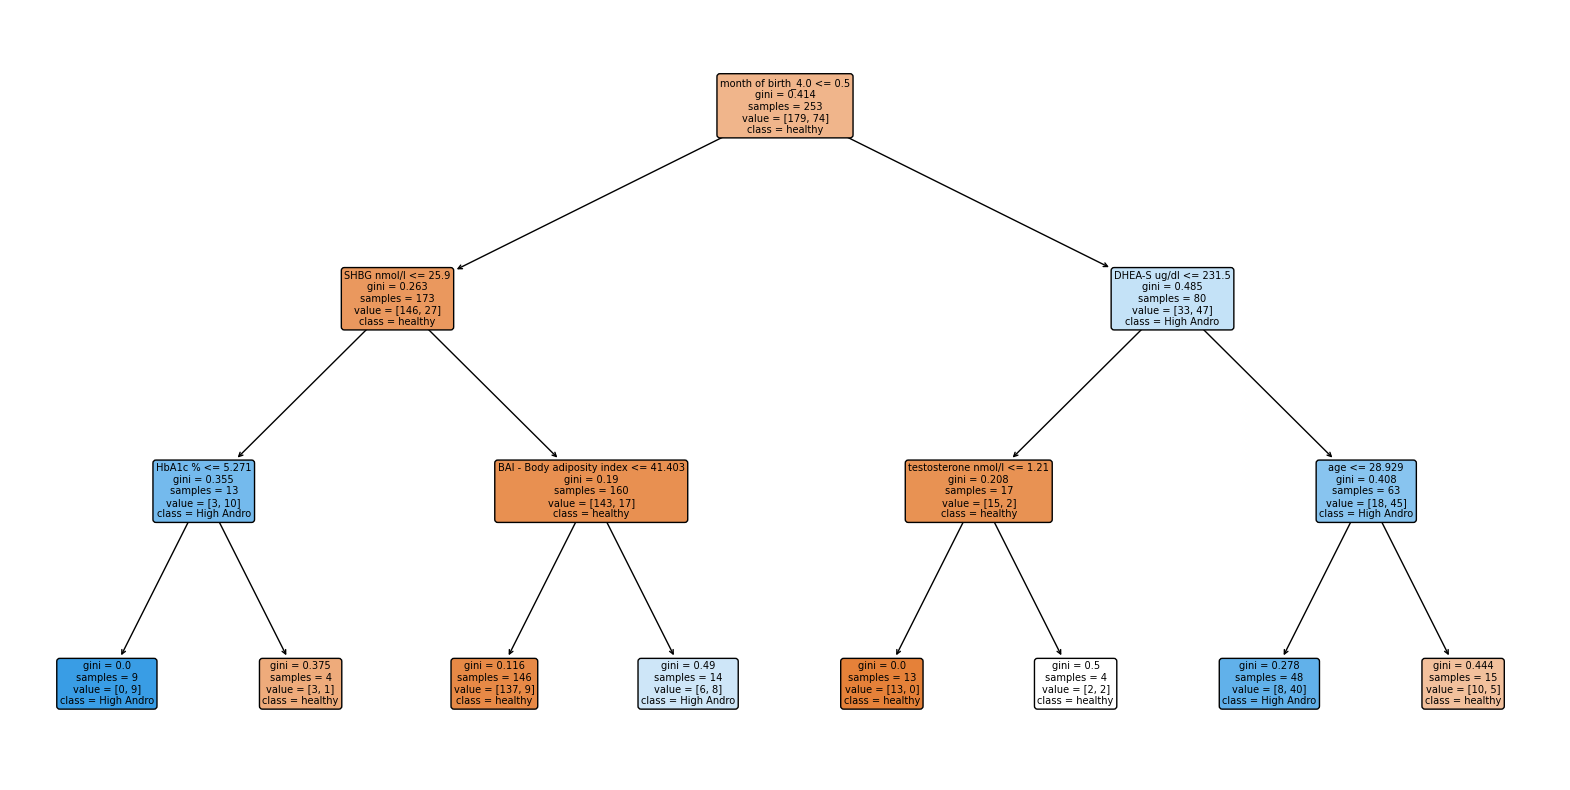

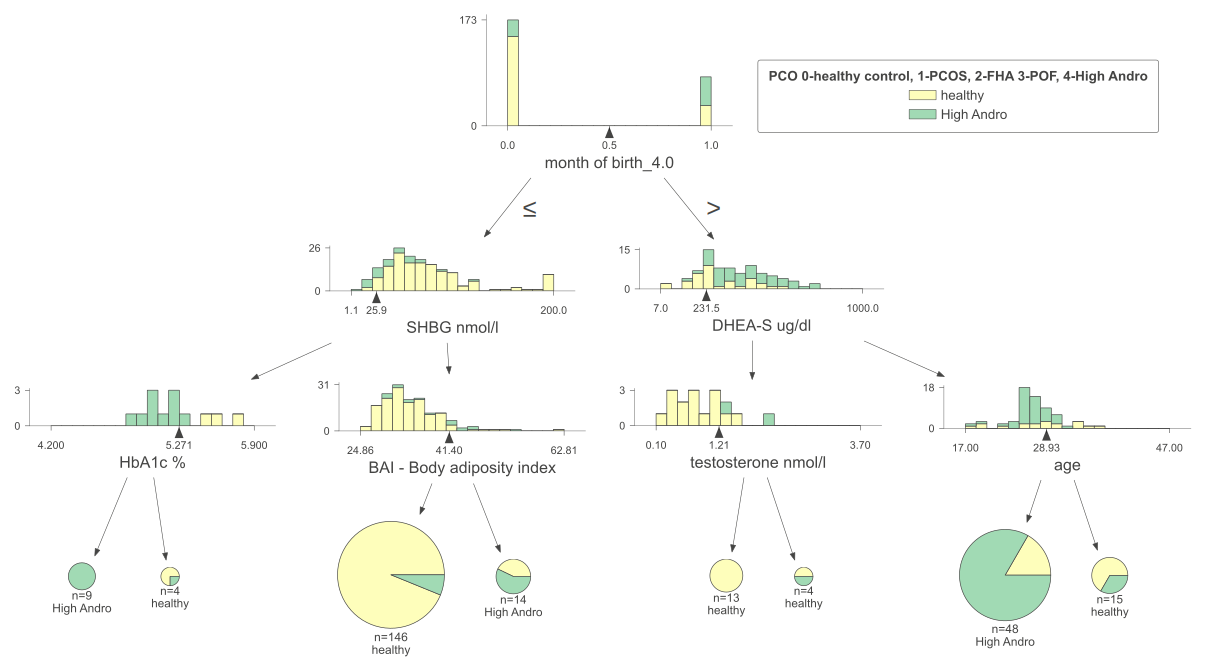

In [51]:
model_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=4, min_samples_split=5, class_weight=None)

feature_importnces_tree, pipeline_tree = validate_model(model_tree, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor_tree, categorical_preprocessor, get_feature_importance_tree)

X_transformed = pipeline_tree['preprocessor'].fit_transform(X_train, y_train)
column_names = pipeline_tree['preprocessor'].get_feature_names_out()

plt.figure(figsize=(20,10))
plot_tree(pipeline_tree['model'], filled=True, rounded=True, feature_names=column_names, class_names=CLASS_NAMES)
plt.savefig('charts/trees/PCO_tree.pdf')
plt.show()

viz_model = dtreeviz.model(pipeline_tree['model'],
                        X_train=X_transformed,
                        y_train=y_train.astype(int),
                        feature_names=column_names,
                        target_name=PCO,
                        class_names=CLASS_NAMES,
                        )

viz_model.view(scale=1.8)

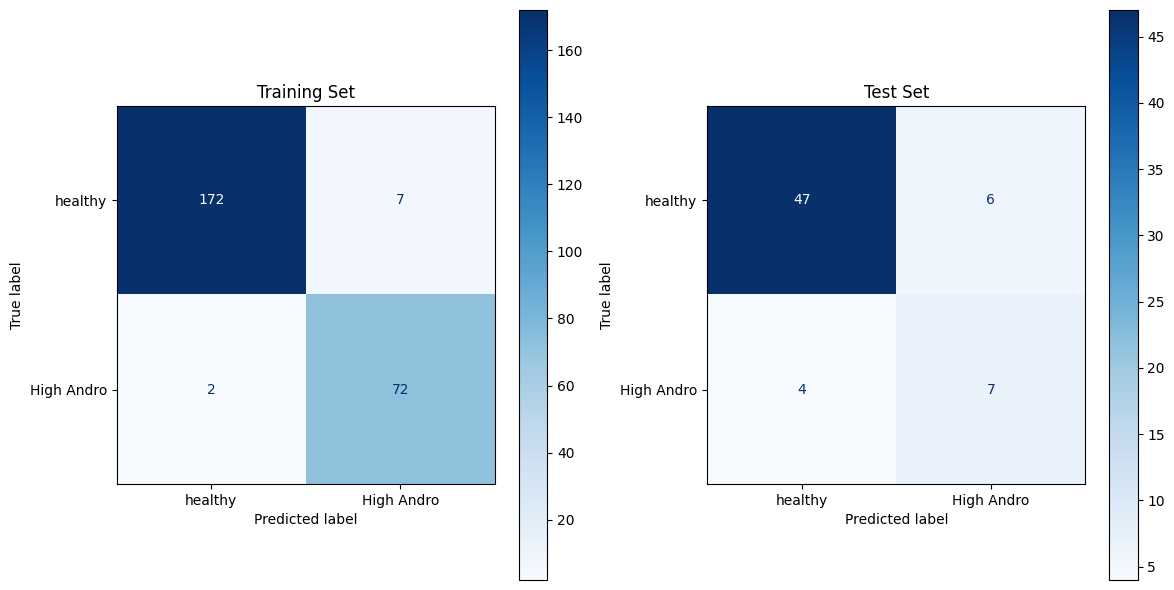

Training set
              precision    recall  f1-score   support

     healthy       0.99      0.96      0.97       179
  High Andro       0.91      0.97      0.94        74

    accuracy                           0.96       253
   macro avg       0.95      0.97      0.96       253
weighted avg       0.97      0.96      0.96       253

Test set
              precision    recall  f1-score   support

     healthy       0.92      0.89      0.90        53
  High Andro       0.54      0.64      0.58        11

    accuracy                           0.84        64
   macro avg       0.73      0.76      0.74        64
weighted avg       0.86      0.84      0.85        64



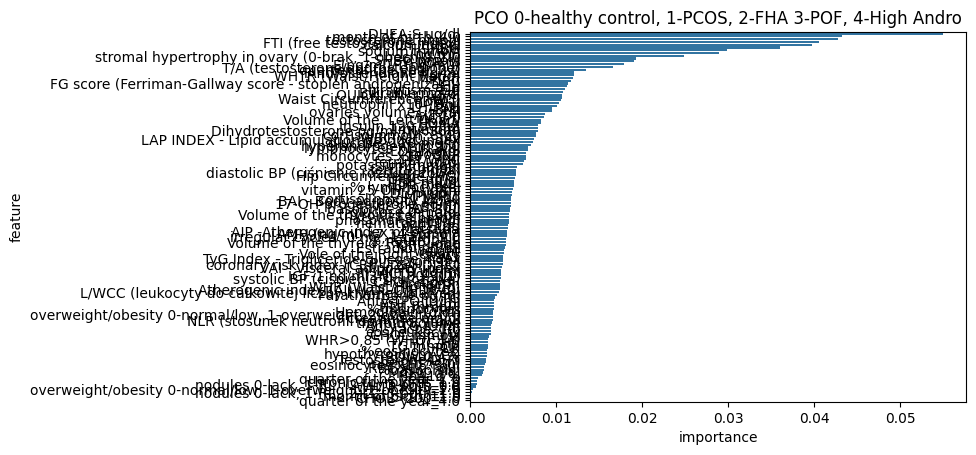

In [50]:
model_rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=5, class_weight='balanced_subsample', random_state=72)

feature_importnces_rf, pipeline_rf = validate_model(model_rf, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor_tree, categorical_preprocessor, get_feature_importance_rf)

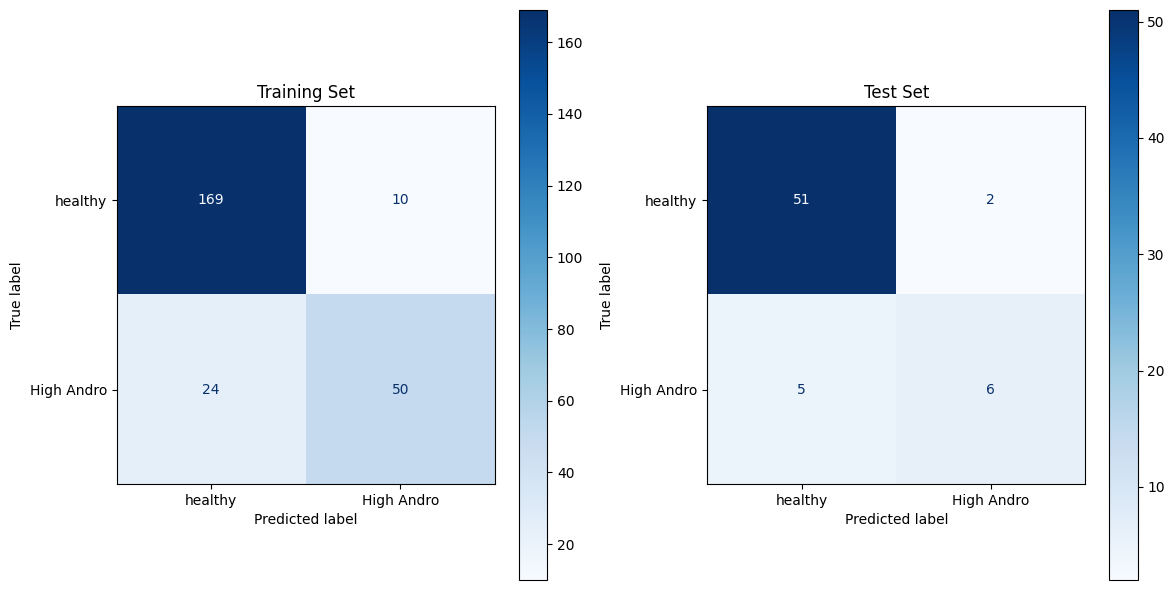

Training set
              precision    recall  f1-score   support

     healthy       0.88      0.94      0.91       179
  High Andro       0.83      0.68      0.75        74

    accuracy                           0.87       253
   macro avg       0.85      0.81      0.83       253
weighted avg       0.86      0.87      0.86       253

Test set
              precision    recall  f1-score   support

     healthy       0.91      0.96      0.94        53
  High Andro       0.75      0.55      0.63        11

    accuracy                           0.89        64
   macro avg       0.83      0.75      0.78        64
weighted avg       0.88      0.89      0.88        64



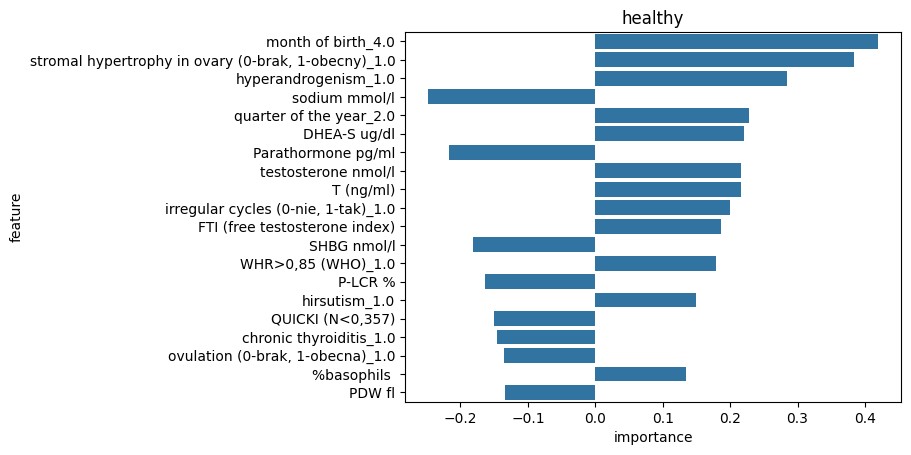

In [48]:

model_lr = LogisticRegression(C=0.1, multi_class='multinomial', max_iter=100000, n_jobs=-1)

feature_importnces_lr, pipeline_tlr = validate_model(model_lr, PCO, X_train, y_train, X_test, y_test, continuous_preprocessor, categorical_preprocessor, get_feature_importance_logistic_regressison)

THe rest--------------------

### Remaining

In [46]:
model = DecisionTreeClassifier()

pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

param_grid = {
    'model__max_depth': [3, 4, 5, 7, 9, 12],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__class_weight': ['balanced', None]
}

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score (f1_weighted):", best_score)

Best parameters: {'model__class_weight': None, 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}
Best score (f1_weighted): 0.7401518887732567


Not balanced
F1 Scores: [0.75851426 0.73212494 0.72404687 0.7253572  0.76647734 0.69018314
 0.76612538 0.74403181 0.70841317 0.73530162 0.72001816 0.73804945
 0.74321216 0.75013194 0.7423934 ], 
Mean F1: 0.736292054817271


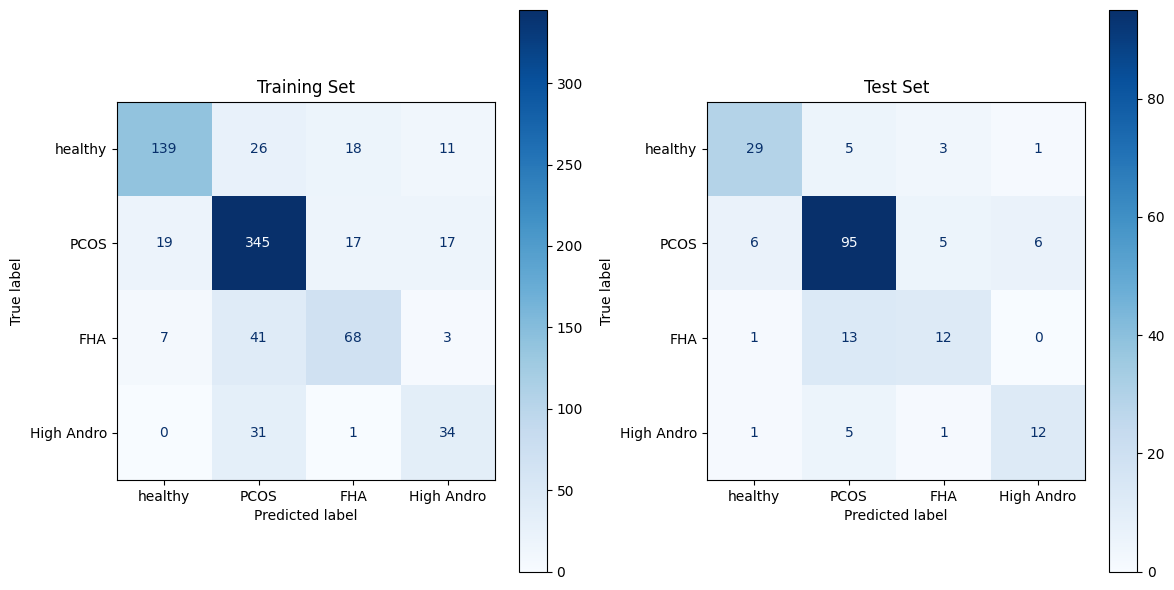

In [49]:
continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])

preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    remainder='passthrough',
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])


print('Not balanced')
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5, class_weight=None)

pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
validate_model(pipeline, preprocessor, X_train, y_train, X_test, y_test)

#### Balanced

F1 Scores: [0.74485283 0.76099339 0.71500126 0.72967718 0.74945908 0.73525168
 0.75782815 0.73779784 0.68071017 0.72467532 0.72830237 0.70531558
 0.7534498  0.74299615 0.73120646], 
Mean F1: 0.7331678187251502


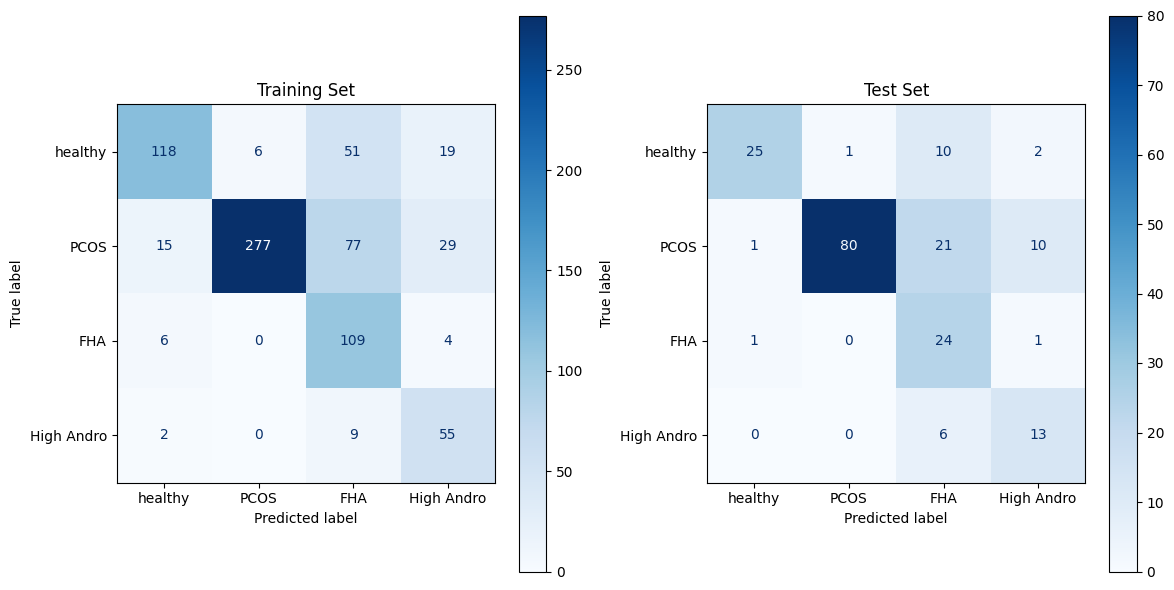

In [101]:
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5, class_weight='balanced')
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
validate_model(pipeline, preprocessor, X_train, y_train, X_test, y_test)

F1 Scores: [0.69558537 0.64734085 0.63151441 0.63634765 0.7110475  0.65301517
 0.67848605 0.61612657 0.58674638 0.61960512 0.66471048 0.64659646
 0.6519676  0.67110714 0.61844587], 
Mean F1: 0.648576174833835


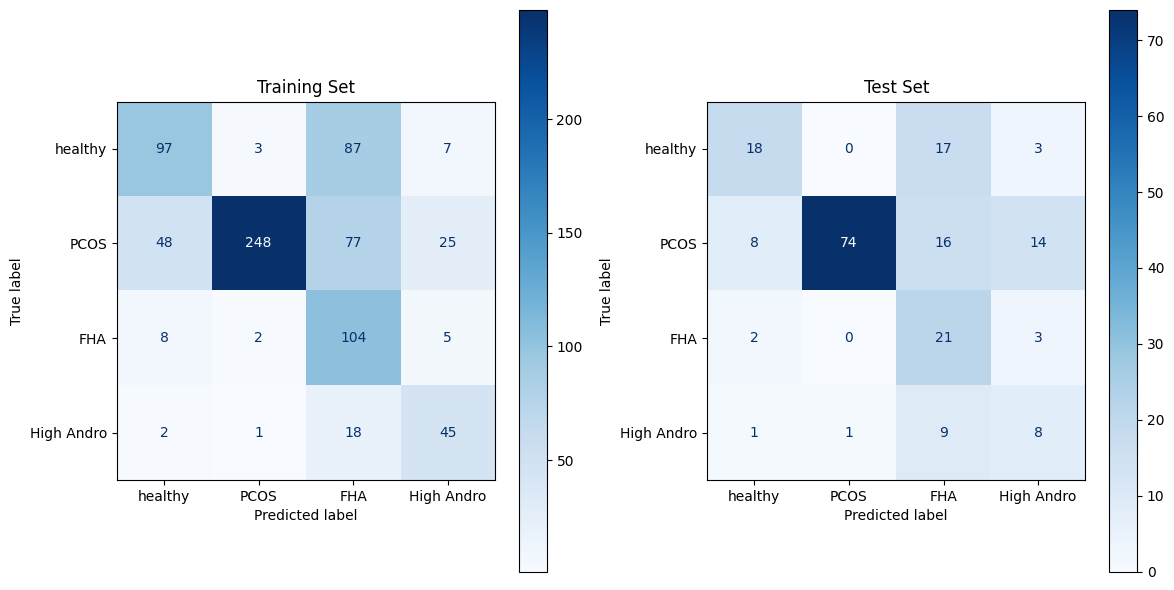

In [88]:
continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))])
# categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))])
#  NOTE: Drzewo działa dużo lepiej kiedy nie zastępujemy brakujących wartości

preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    remainder='passthrough',
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5, class_weight='balanced')


pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

validate_model(pipeline, preprocessor, X_train, y_train, X_test, y_test)

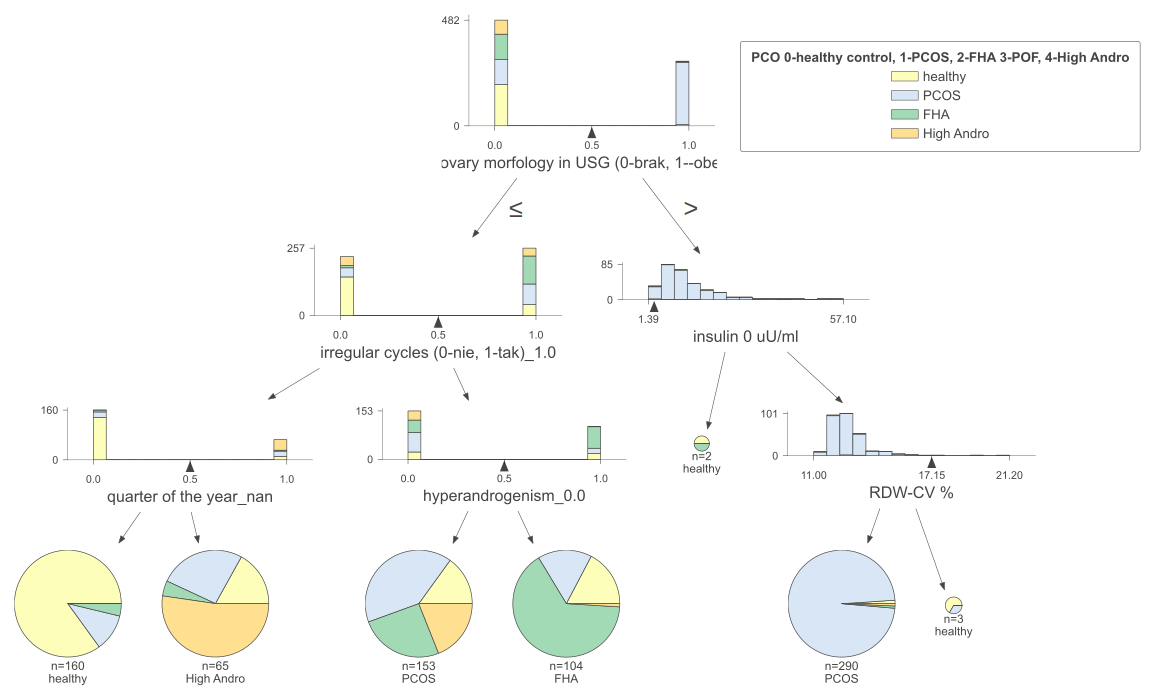

In [98]:
continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))])

preprocessor = ColumnTransformer(
    verbose_feature_names_out=False,
    remainder='passthrough',
    transformers=[
        ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
        ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
    ])

model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, min_samples_split=5, class_weight=None)

pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])

pipeline.fit(X_train, y_train)
X_transformed = preprocessor.fit_transform(X_train, y_train)
column_names = pipeline['preprocessor'].get_feature_names_out()


viz_model = dtreeviz.model(model,
                           X_train=X_transformed, y_train=y_train.astype(int),
                           feature_names=column_names,
                           target_name=PCO,
                           class_names=CLASS_NAMES,
                           )

viz_model.view(scale=1.8)

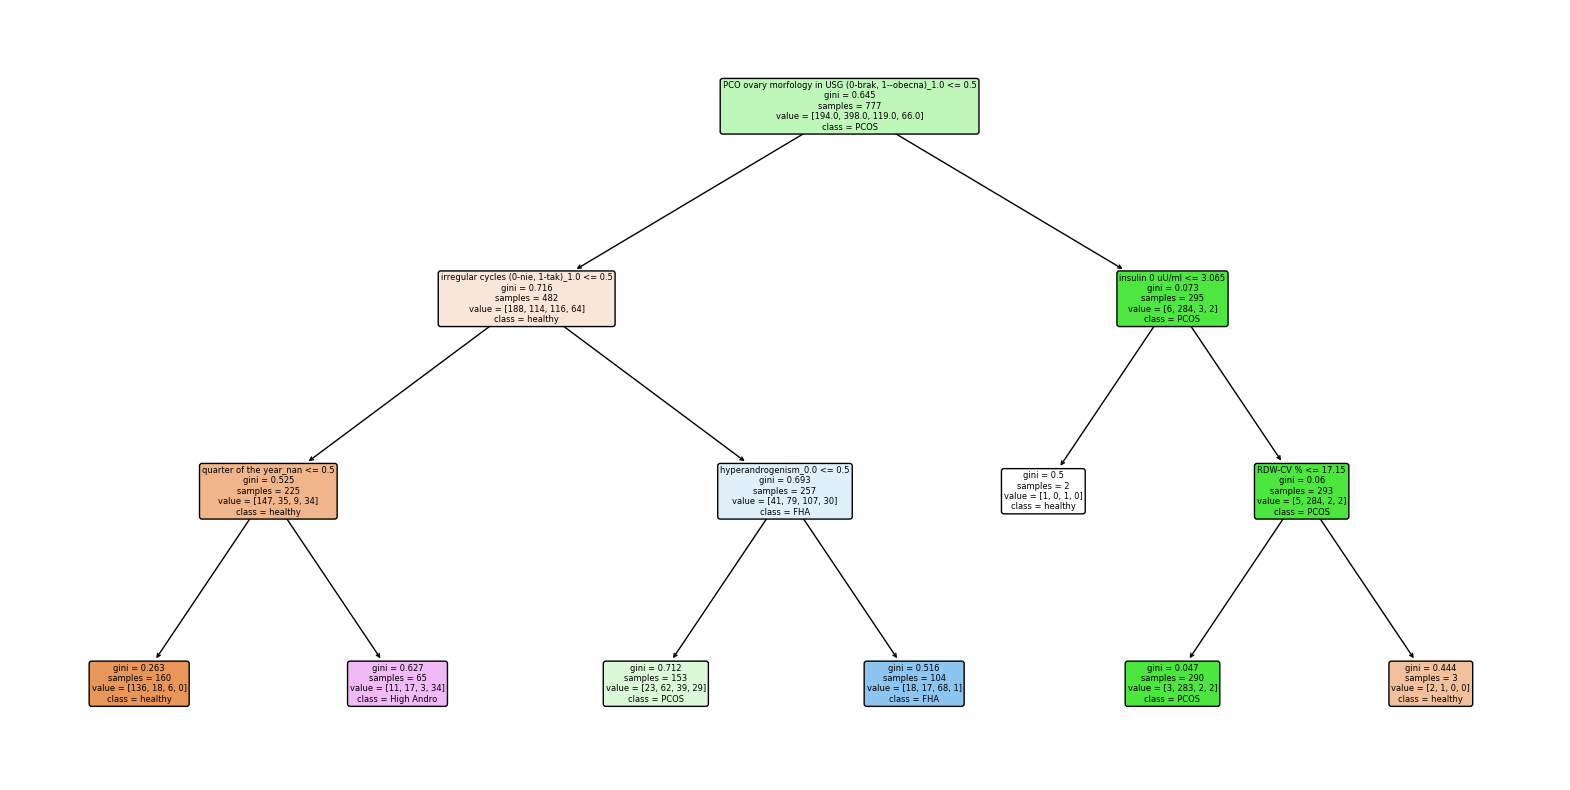

In [99]:
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, rounded=True, feature_names=column_names, class_names=CLASS_NAMES)
plt.savefig('charts/trees/PCO_tree.pdf')
plt.show()

## Feature importances


## Feature selection methods

In [93]:
selector = VarianceThreshold(threshold=0.001)
selector.set_output(transform='pandas')
selector.fit_transform(X_train)

kept_features_mask = selector.get_support()

print("Usunięte cechy:", [X_train.columns[i] for i, keep in enumerate(kept_features_mask) if not keep])

Usunięte cechy: ['basophils x10^3/ul', 'NRBC x10^3/ul', 'MPV/PLT', 'eos/leukocyty', 'Testosterone/DHT']


### SelectKBest

In [94]:

from sklearn.feature_selection import f_classif


def feature_selection(feature_selection_model, X_train, y_train):
    preprocessor = ColumnTransformer(
        verbose_feature_names_out=False,
        transformers=[
            ('num', continuous_preprocessor, CONTINUOUS_ATTRIBUTES),
            ('cat', categorical_preprocessor, get_categorical_attributes_except(PCO))
        ])
    pipeline = Pipeline([('preprocessor', preprocessor), ('feature_selection', feature_selection_model)])

    X_new = pipeline.fit_transform(X_train, y_train)

    selected_indices = feature_selection_model.get_support(indices=True)
    selected_feature_names = [preprocessor.get_feature_names_out()[i] for i in selected_indices]
    print(selected_feature_names)

    return pd.DataFrame(X_new, columns=selected_feature_names)


feature_selection(SelectKBest(f_classif, k=10), X_train, y_train).head()

['ovaries volume - total', 'irregular cycles (0-nie, 1-tak)_1.0', 'ovulation (0-brak, 1-obecna)_0.0', 'PCO ovary morfology in USG (0-brak, 1--obecna)_0.0', 'PCO ovary morfology in USG (0-brak, 1--obecna)_1.0', 'PCO ovary morfology in USG (0-brak, 1--obecna)_nan', 'nodules 0-lack, 1-RL,  2-LL, 3-both_nan', 'chronic thyroiditis_nan', 'follicules >12_1.0', 'quarter of the year_nan']


ovaries volume - total  irregular cycles (0-nie, 1-tak)_1.0  ovulation (0-brak, 1-obecna)_0.0  PCO ovary morfology in USG (0-brak, 1--obecna)_0.0  PCO ovary morfology in USG (0-brak, 1--obecna)_1.0  PCO ovary morfology in USG (0-brak, 1--obecna)_nan  nodules 0-lack, 1-RL,  2-LL, 3-both_nan  chronic thyroiditis_nan  follicules >12_1.0  quarter of the year_nan
0                9.666800                                  1.0                               0.0                                                 0.0                                                 0.0                                                 1.0                                      1.0                      1.0                 0.0                      1.0
1               18.290000                                  1.0                               0.0                                                 0.0                                                 1.0                                                 0.0                                      0.0                      0.0                 0.0                      0.0
2                8.150000                                  1.0                               1.0                                                 1.0                                                 0.0                                                 0.0                                      0.0                      0.0                 0.0                      0.0
3               17.371722                                  1.0                               0.0                                                 1.0                                                 0.0                                                 0.0                                      0.0                      0.0                 0.0                      0.0
4               27.980000                                  1.0                               1.0                                                 0.0                                                 1.0                                                 0.0                                      0.0                      0.0                 1.0                      0.0

### Recursive feature elimination

Optimal number of features: 3
['irregular cycles (0-nie, 1-tak)_1.0'
 'PCO ovary morfology in USG (0-brak, 1--obecna)_1.0'
 'nodules 0-lack, 1-RL,  2-LL, 3-both_nan']


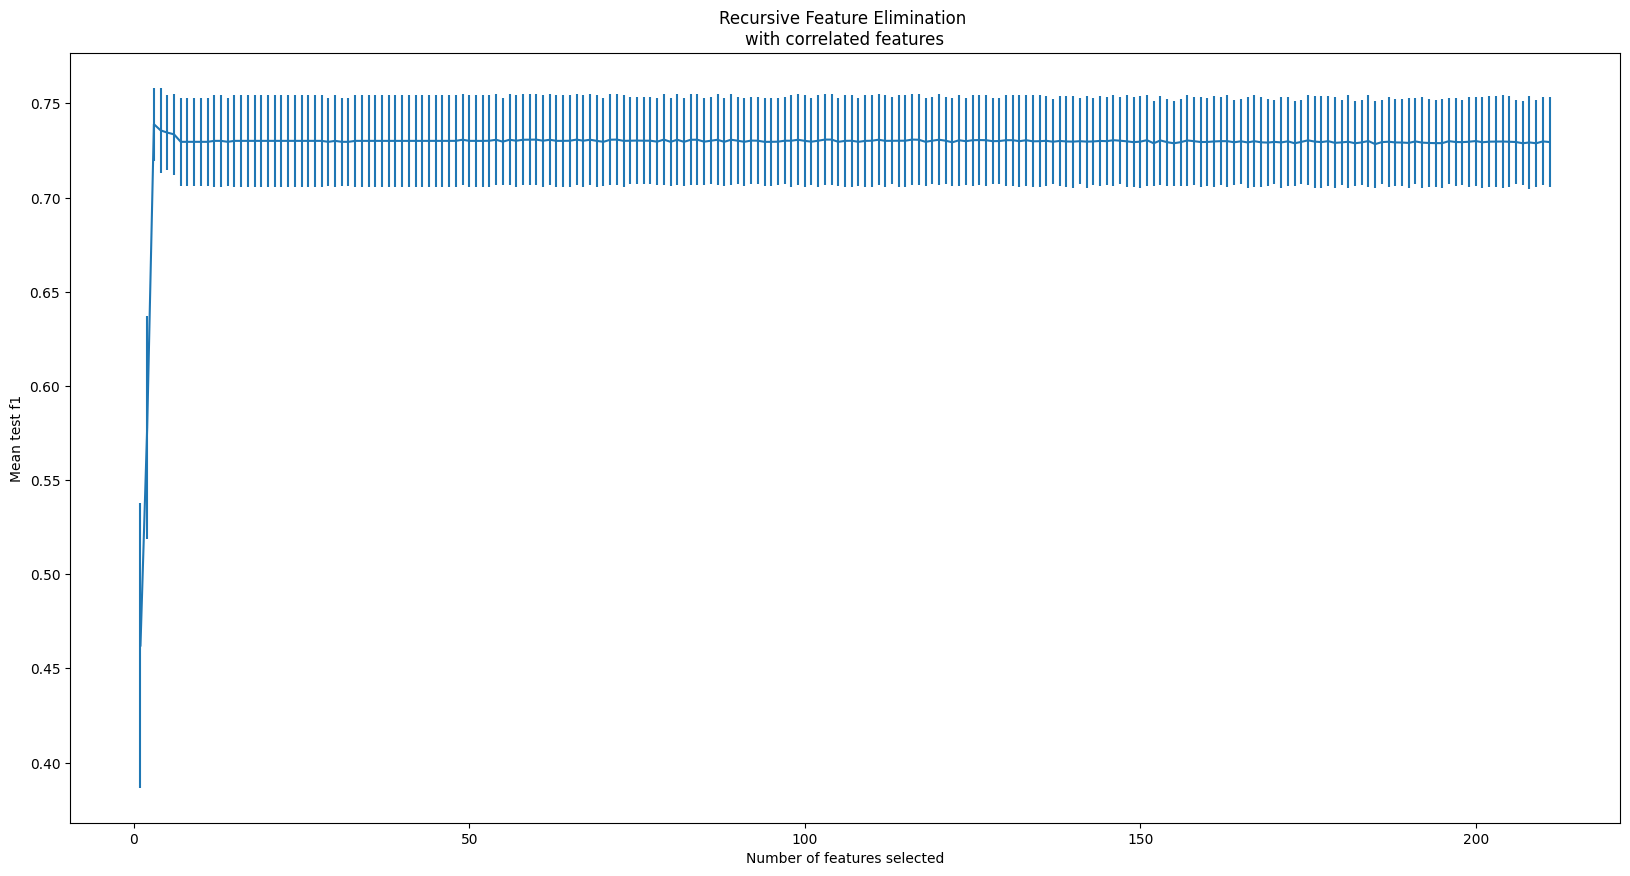

In [95]:
min_features_to_select = 1
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring="f1_weighted",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

pipeline = Pipeline([('preprocessor', preprocessor), ('fs', rfecv)])
pipeline.fit(X_train, y_train)

selected_feature_indices = rfecv.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]

# print(len(preprocessor.get_feature_names_out()))
print(f"Optimal number of features: {rfecv.n_features_}")
# print(rfecv.get_feature_names_out())
print(selected_feature_names)

n_scores = len(rfecv.cv_results_["mean_test_score"])
scores = abs(rfecv.cv_results_["mean_test_score"])

plt.figure(figsize=(20,10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test f1")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    scores,
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### SelectFromModel

In [96]:
cv = RepeatedKFold(n_repeats=5, n_splits=5, random_state=42)
sel_from_model = SelectFromModel(
    estimator=model,
)

pipeline = Pipeline([('preprocessor', preprocessor), ('sel_from_model', sel_from_model)])
pipeline.fit(X_train, y_train)

selected_feature_indices = sel_from_model.get_support(indices=True)
selected_feature_names = preprocessor.get_feature_names_out()[selected_feature_indices]
selected_feature_names

array(['weight', 'height (cm)', 'FTI (free testosterone index)',
       'irregular cycles (0-nie, 1-tak)_1.0',
       'PCO ovary morfology in USG (0-brak, 1--obecna)_1.0',
       'hypothyroidism_nan', 'nodules 0-lack, 1-RL,  2-LL, 3-both_nan'],
      dtype=object)

### Permutation importance

In [97]:
pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

result = permutation_importance(pipeline, X_train, y_train, n_repeats=5, random_state=42, n_jobs=-1, scoring='f1_weighted')
importances = result.importances_mean

feature_importances = dict(zip(preprocessor.get_feature_names_out(), importances))

sorted_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)

df_importances = pd.DataFrame(sorted_importances, columns=['feature', 'importance'])

df_importances.head(15)

feature  importance
0                                            neutrophil x10^3/ul    0.294271
1                                         ovaries volume - total    0.117194
2                                                    RBC x10^6ul    0.067505
3   overweight/obesity 0-normal/low, 1-overweight, 2-obesity_0.0    0.017257
4                                                         weight    0.005064
5                                                 % lymphocytes     0.003560
6                                                      WC>88_nan    0.002171
7                                                    height (cm)    0.001458
8                                               Hypertension_0.0    0.000490
9                                                Bilirubin mg/dl    0.000179
10                                                    LDL mmol/l    0.000133
11                                                        PDW fl    0.000113
12                                                 eos/leukocyty    0.000113
13                                                     TG mmol/l    0.000113
14                                               insulin 0 uU/ml    0.000113